# Course Work

In [ ]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import time
import keras

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from keras.utils import plot_model
from keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

Підключення до диску.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Розпакуємо з архіву дані.

In [ ]:
import zipfile
import os
import time

# Шлях до архіву
archive_path = '/content/drive/MyDrive/brain-tumor-mri-dataset.zip'

# Папка, куди розпакувати архів
extract_dir = '/content/drive/MyDrive/brain-tumor-dataset'

# Розпаковка архіву
start_time = time.time()  # початковий час
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
end_time = time.time()  # кінцевий час
full_time = end_time - start_time

print("Архів розпаковано успішно.")
print(f"Час розпакування: {full_time} секунд")

Створимо функції з послідовностей перетворень зображень датасету, які потім застосуємо до даних: тренувальних та валідаційних.

In [ ]:
def train_transform(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224 пікселі
    image = tf.image.random_flip_left_right(image)  # випадкове перевертання по горизонталі
    image = tf.image.random_flip_up_down(image)  # аналогічно по вертикалі
    image = tf.image.random_brightness(image, 0.2)  # випадкова зміна яскравости
    image = tf.image.random_contrast(image, 0.8, 1.2)  # та контрасту
    image = tf.image.random_saturation(image, 0.8, 1.2)  # випадкова зміна насиченості
    image = tf.image.random_hue(image, 0.1)  # випадкова зміна відтінку
    #image = tf.image.central_crop(image, central_fraction=0.8)  # випадкове обрізання центральної частини
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # випадкове обертання на 90 градусів
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація до діапазону [0, 1]
    return image, label

def val_transform(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація до діапазону [0, 1]
    return image, label

In [ ]:
import pathlib  # для директорії з даними

dataset_path_train = '/content/drive/MyDrive/brain-tumor-dataset/Training'
data_dir_train = pathlib.Path(dataset_path_train)  # об'єкт із шляхом до датасету, тренувальний набір, на диску

dataset_path_test = '/content/drive/MyDrive/brain-tumor-dataset/Testing'
data_dir_test = pathlib.Path(dataset_path_test)  # об'єкт із шляхом до датасету, тестувальний набір,  на диску

In [ ]:
image_count_tr = len(list(data_dir_train.glob('*/*.jpg')))
print('Training:', image_count_tr)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Testing:', image_count_test)
print('Total images count:', image_count_tr + image_count_test)

Training: 5712
Testing: 1311
Total images count: 7023


Створимо набір тренувальних даних через директорію:

In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,  # шлях
  batch_size=32)  # розмір "партії" даних

Found 5712 files belonging to 4 classes.


Аналогічно створимо набір валідаційних даних через директорію:

In [ ]:
ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  batch_size=32)

Found 1311 files belonging to 4 classes.


Назви класів:

In [ ]:
class_names = ds_train.class_names
classes_count = len(class_names)
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

Застосуємо перетворення зображень.

Просто map.

In [ ]:
start_time = time.time()
train_ds = ds_train.map(train_transform)
val_ds = ds_val.map(val_transform)
end_time = time.time()

training_time = end_time - start_time
print(f"Час: {training_time} секунд")

Час: 0.2408146858215332 секунд


Використаємо дві хитрі функції для підвищення швидкості навчання.<br>

*   Метод .cache() збереже дані у пам'яті після першого читання, що дозволить уникнути повторного читання з диска при наступних епохах тренування.<br>
*   Метод .prefetch() завантажить зображення з датасету у фоновому режимі під час тренування моделі, що дозволить підвищити ефективність використання ресурсів під час тренування.<br>

*   Параметр buffer_size=AUTOTUNE дозволяє автоматично вибрати оптимальний розмір буфера для кешування та попереднього завантаження, використовуючи константу AUTOTUNE.





In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Моделі по filter_size та pool_size

### №1

filter_size = (4, 4)<br>
pool_size = (2, 2)

In [ ]:
model1 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, (4, 4), activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist1 = model1.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
179/179 [==============================] - 132s 684ms/step - loss: 1.0271 - accuracy: 0.5669 - val_loss: 0.7925 - val_accuracy: 0.6934
Epoch 2/10
179/179 [==============================] - 46s 254ms/step - loss: 0.7154 - accuracy: 0.7143 - val_loss: 0.7324 - val_accuracy: 0.7246
Epoch 3/10
179/179 [==============================] - 80s 441ms/step - loss: 0.5821 - accuracy: 0.7778 - val_loss: 0.5753 - val_accuracy: 0.7674
Epoch 4/10
179/179 [==============================] - 77s 417ms/step - loss: 0.4896 - accuracy: 0.8102 - val_loss: 0.5624 - val_accuracy: 0.7704
Epoch 5/10
179/179 [==============================] - 58s 316ms/step - loss: 0.4425 - accuracy: 0.8279 - val_loss: 0.4512 - val_accuracy: 0.8185
Epoch 6/10
179/179 [==============================] - 59s 323ms/step - loss: 0.3923 - accuracy: 0.8470 - val_loss: 0.4372 - val_accuracy: 0.8139
Epoch 7/10
179/179 [==============================] - 52s 286ms/step - loss: 0.3306 - accuracy: 0.8768 - val_loss: 0.3570 - val_a

Збереження моделі:

In [ ]:
model1.save('/content/drive/MyDrive/brain-tumor-models/model1')

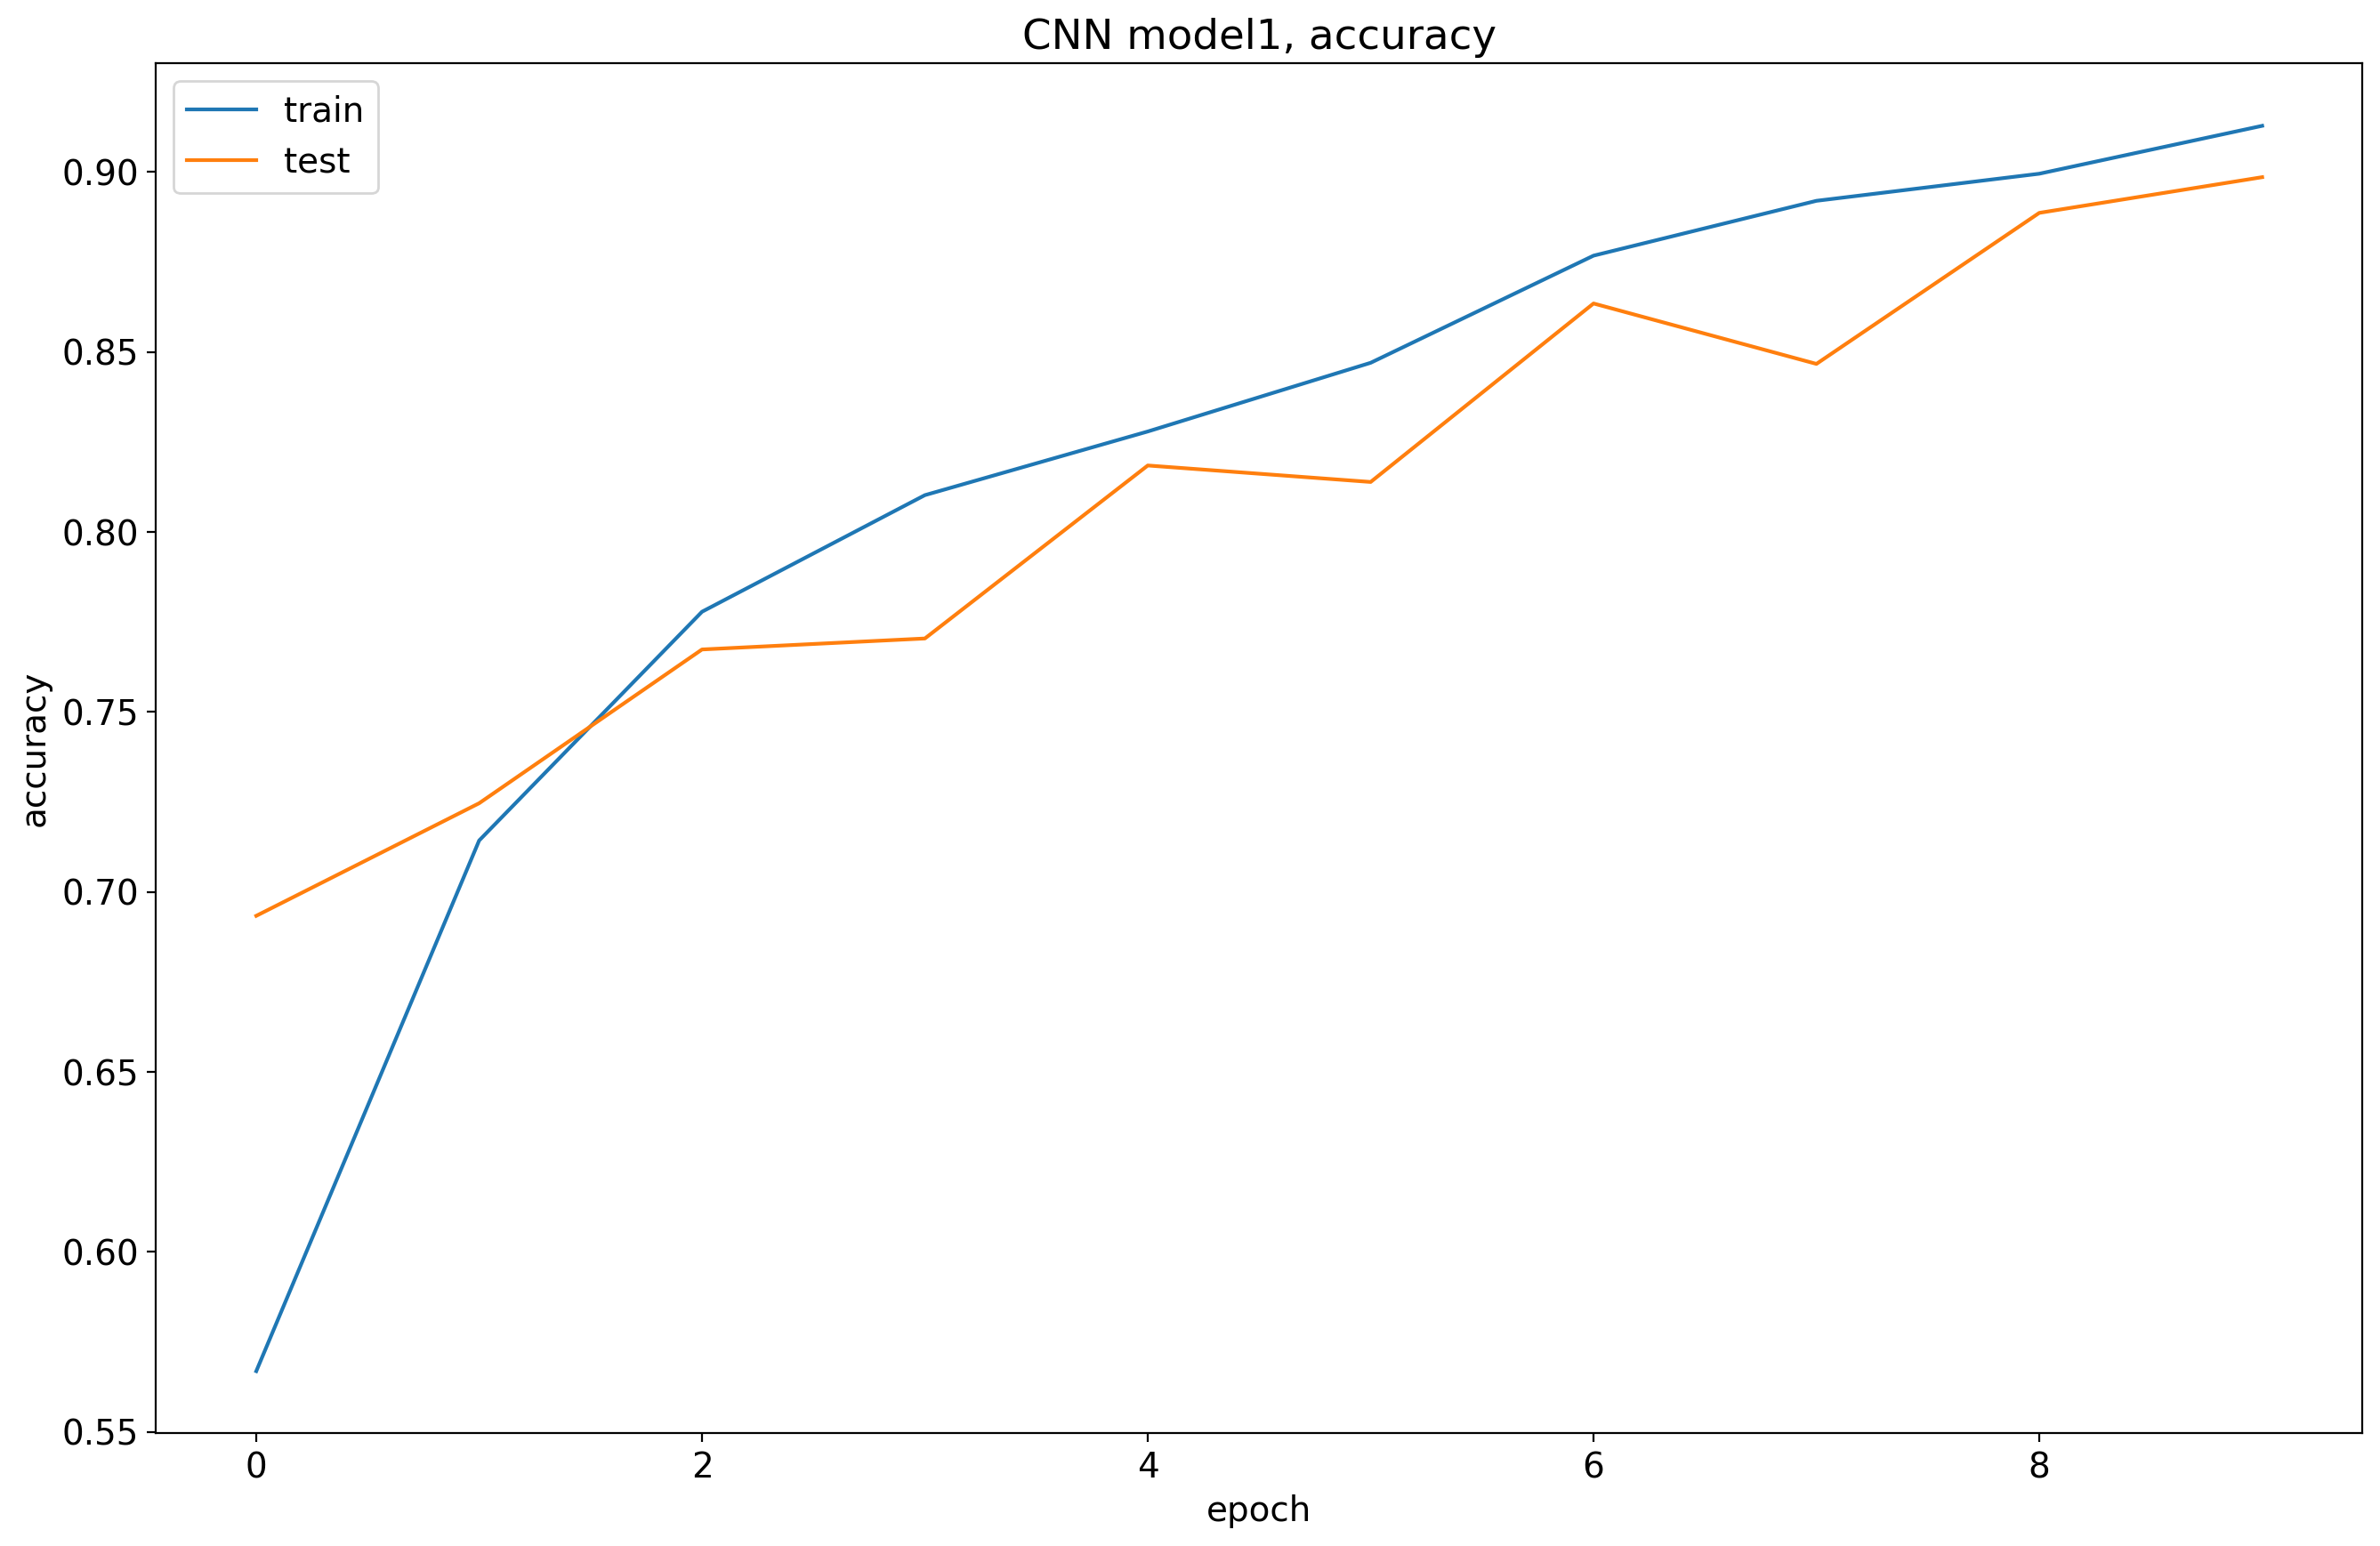

In [ ]:
# графік навчання, точність моделі
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('CNN model1, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

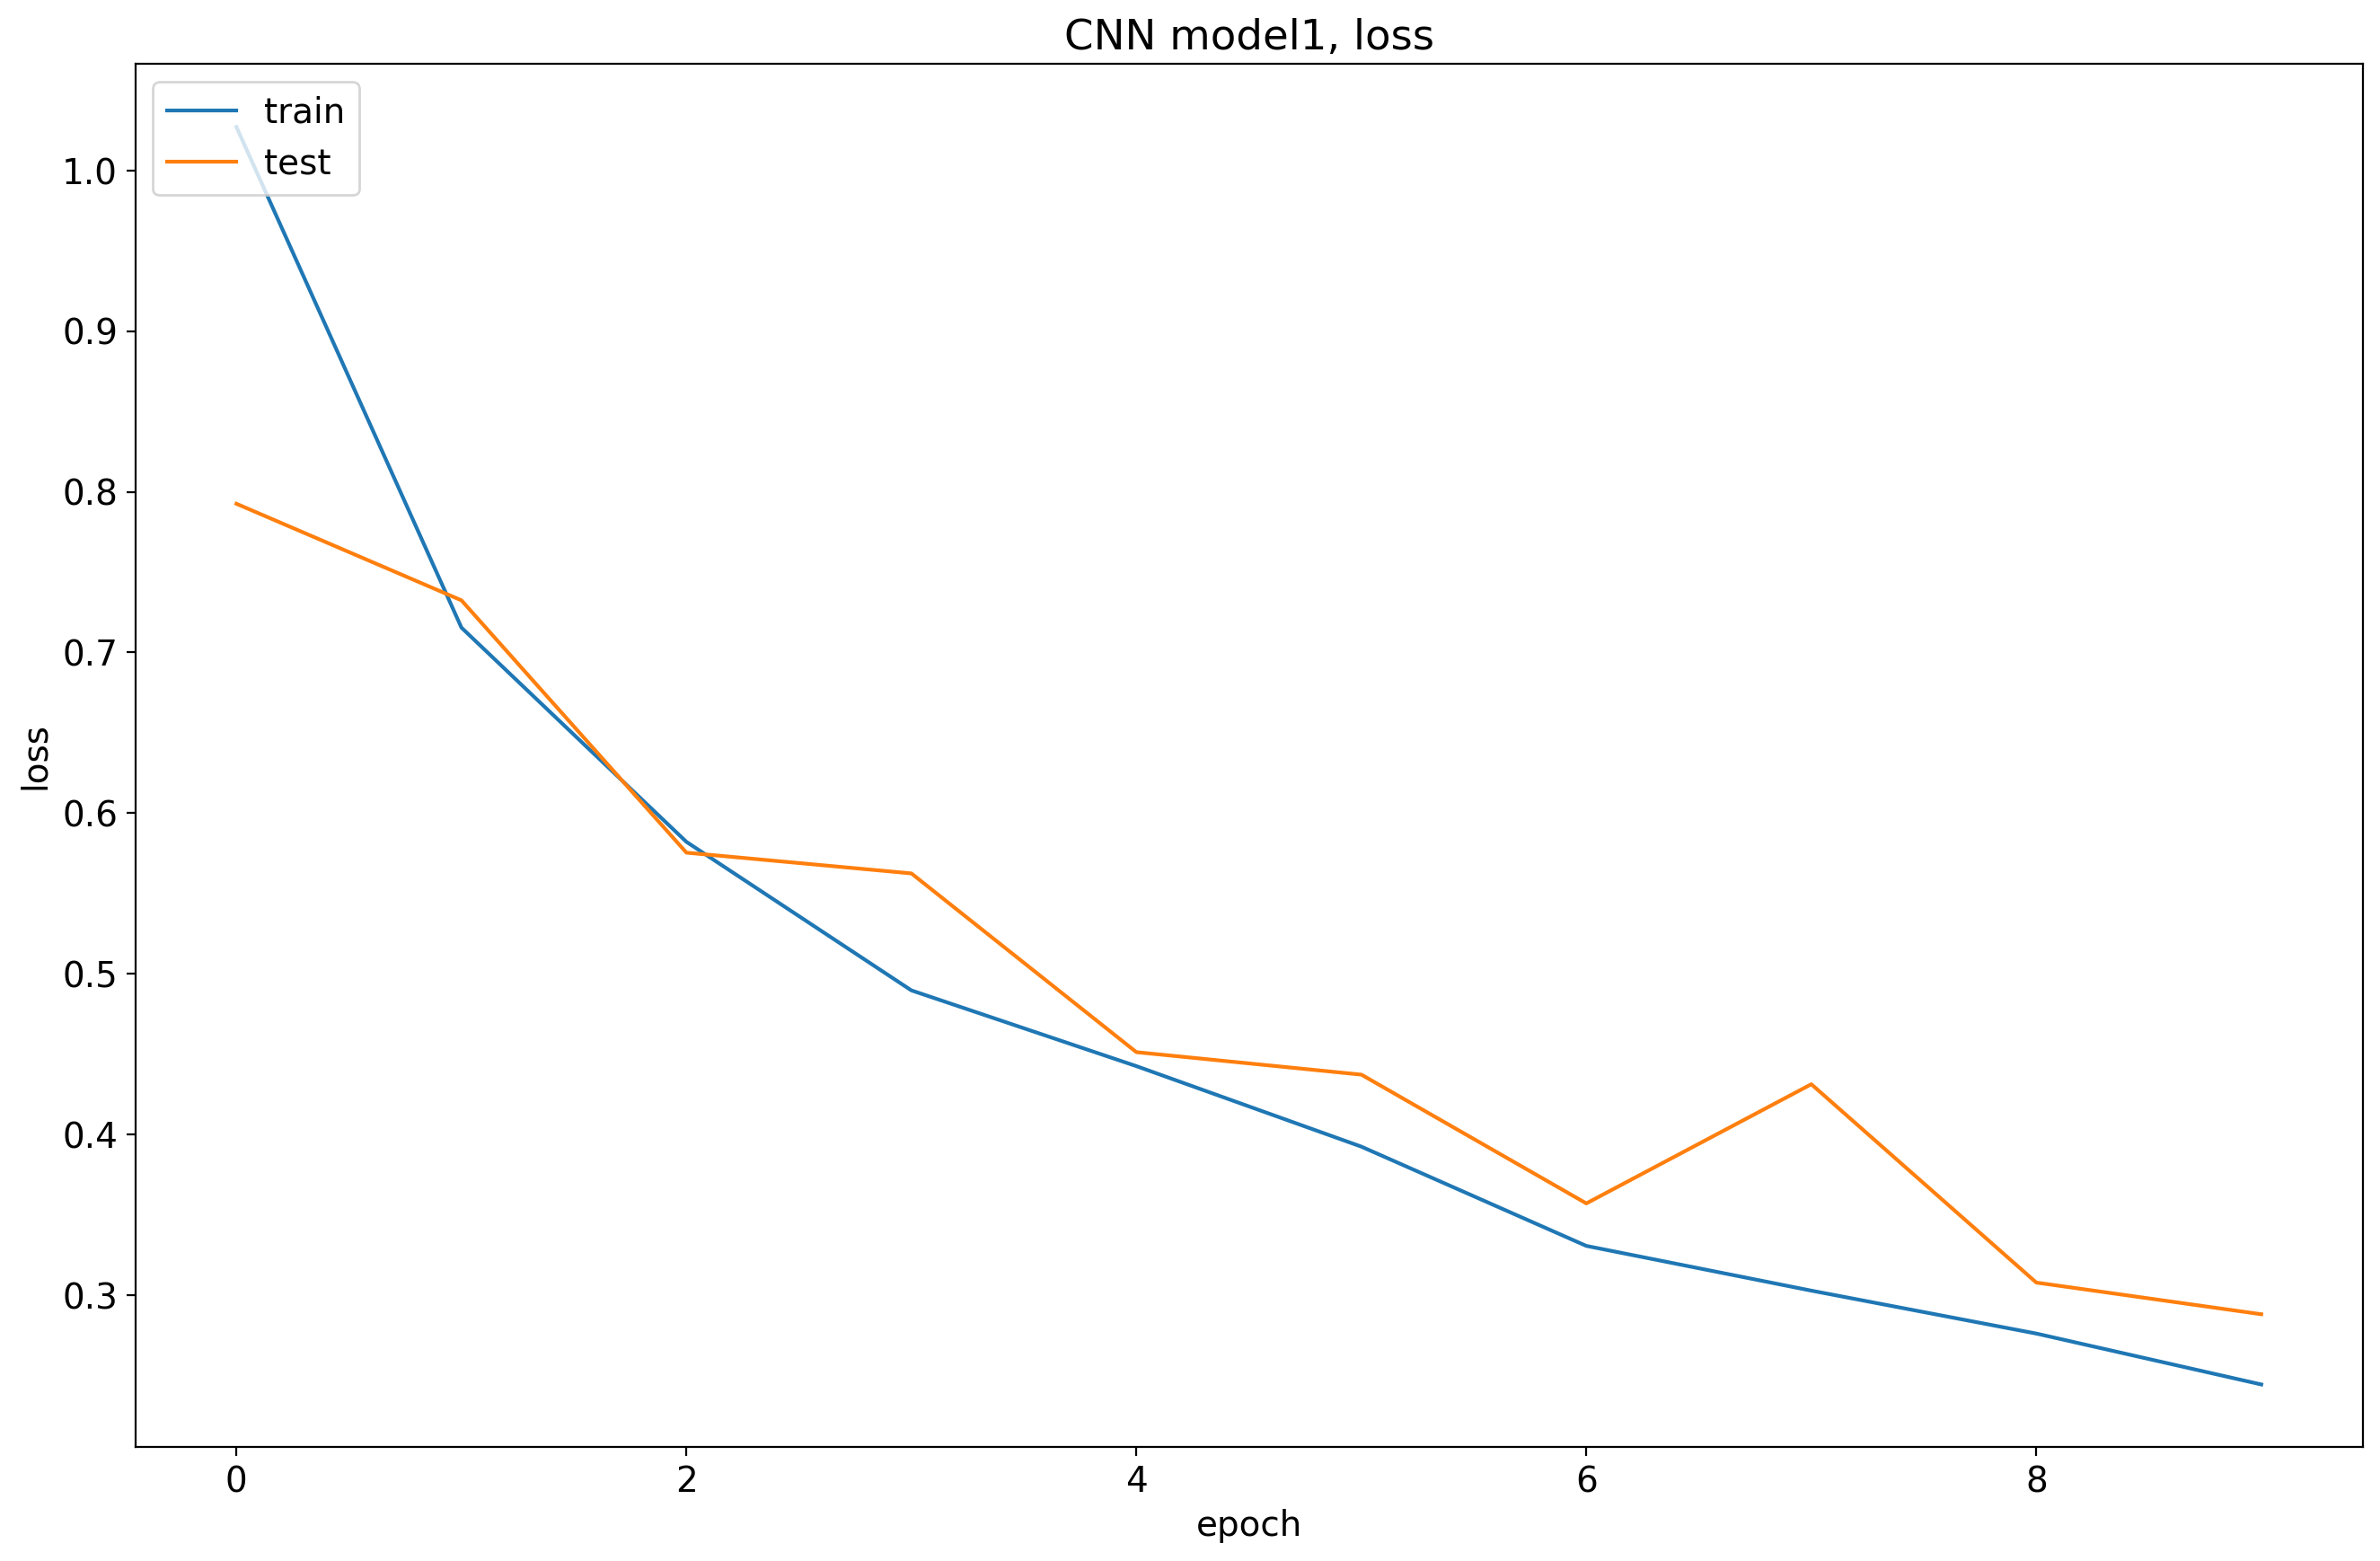

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('CNN model1, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model1.evaluate(train_ds, verbose=1)
valid_score = model1.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 106ms/step - loss: 0.2880 - accuracy: 0.8986
Train Loss: 0.1873
Train Accuracy: 92.61%
--------------------
Validation Loss: 0.2880
Validation Accuracy: 89.86%


### №2

filter_size = (4, 4)<br>
pool_size = (3, 3)

In [ ]:
model2 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist2 = model2.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
179/179 [==============================] - 70s 340ms/step - loss: 0.9972 - accuracy: 0.5567 - val_loss: 0.9006 - val_accuracy: 0.6072
Epoch 2/10
179/179 [==============================] - 49s 269ms/step - loss: 0.6378 - accuracy: 0.7542 - val_loss: 0.7403 - val_accuracy: 0.6926
Epoch 3/10
179/179 [==============================] - 44s 241ms/step - loss: 0.5203 - accuracy: 0.8008 - val_loss: 0.5586 - val_accuracy: 0.7719
Epoch 4/10
179/179 [==============================] - 45s 244ms/step - loss: 0.4145 - accuracy: 0.8461 - val_loss: 0.4394 - val_accuracy: 0.8131
Epoch 5/10
179/179 [==============================] - 45s 244ms/step - loss: 0.3732 - accuracy: 0.8620 - val_loss: 0.3482 - val_accuracy: 0.8665
Epoch 6/10
179/179 [==============================] - 46s 252ms/step - loss: 0.3046 - accuracy: 0.8841 - val_loss: 0.3132 - val_accuracy: 0.8833
Epoch 7/10
179/179 [==============================] - 45s 244ms/step - loss: 0.2728 - accuracy: 0.9030 - val_loss: 0.3571 - val_ac

Збереження моделі:

In [ ]:
model2.save('/content/drive/MyDrive/brain-tumor-models/model2')

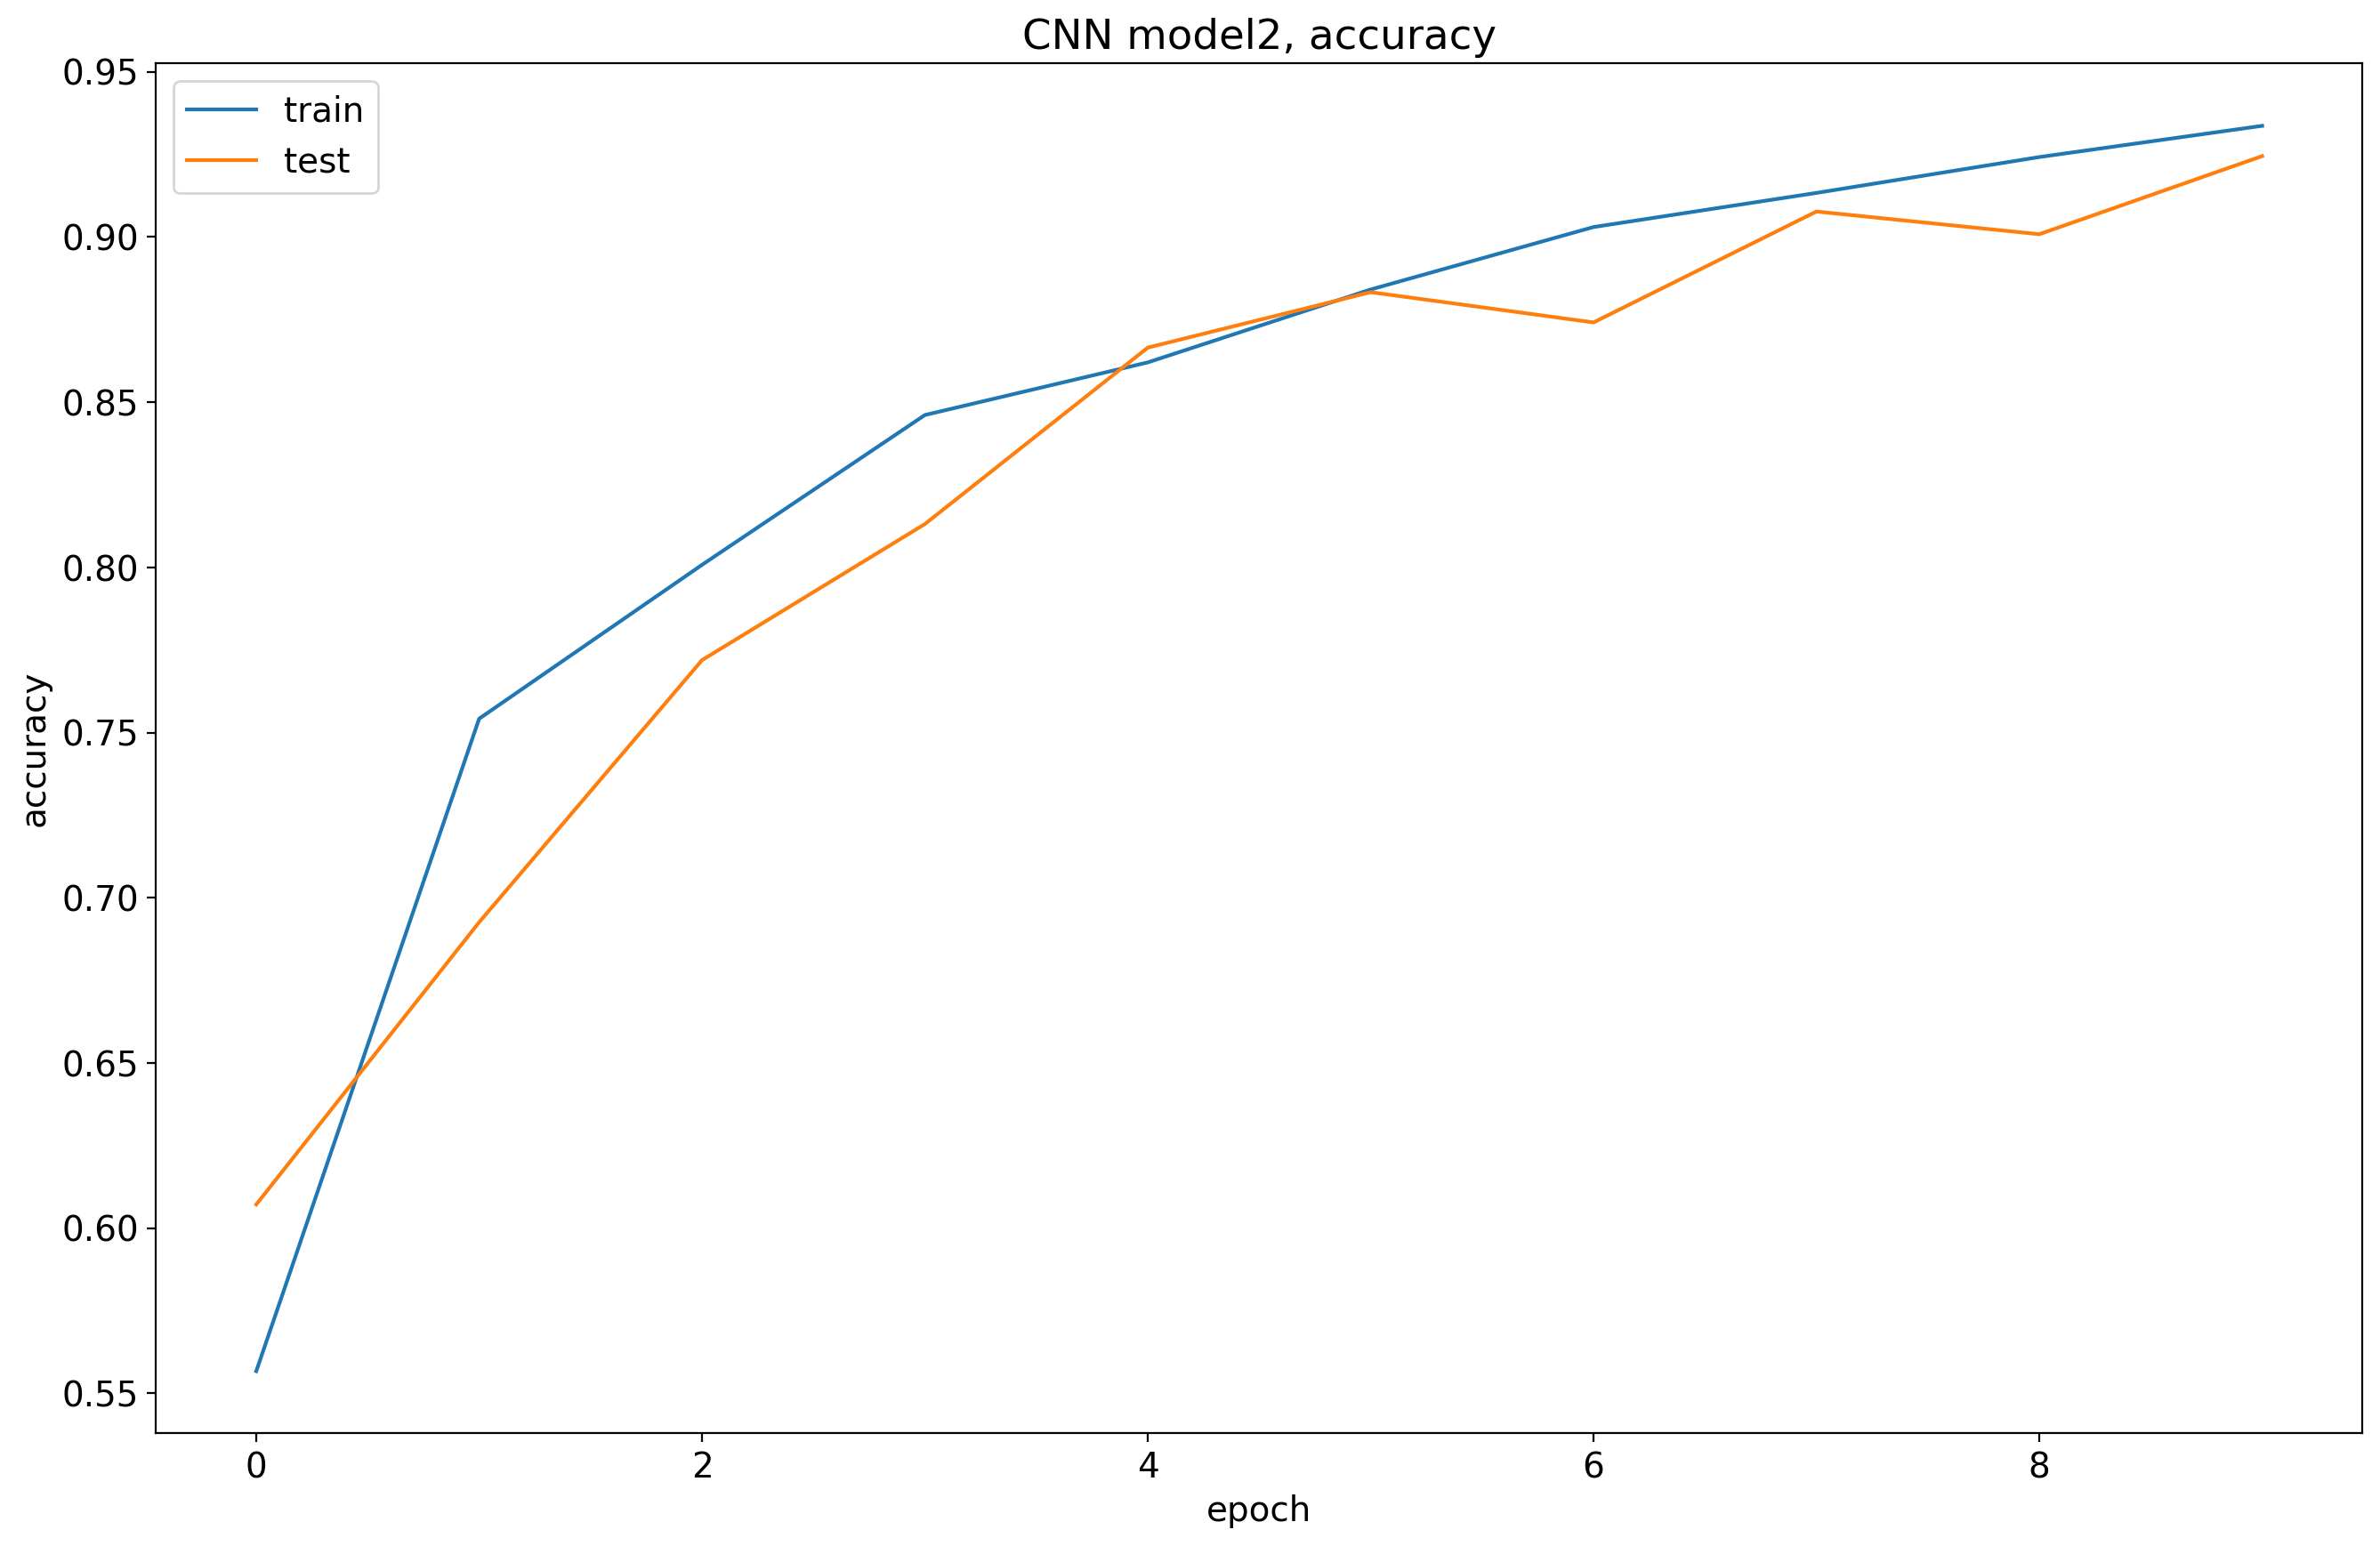

In [ ]:
# графік навчання, точність моделі
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('CNN model2, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

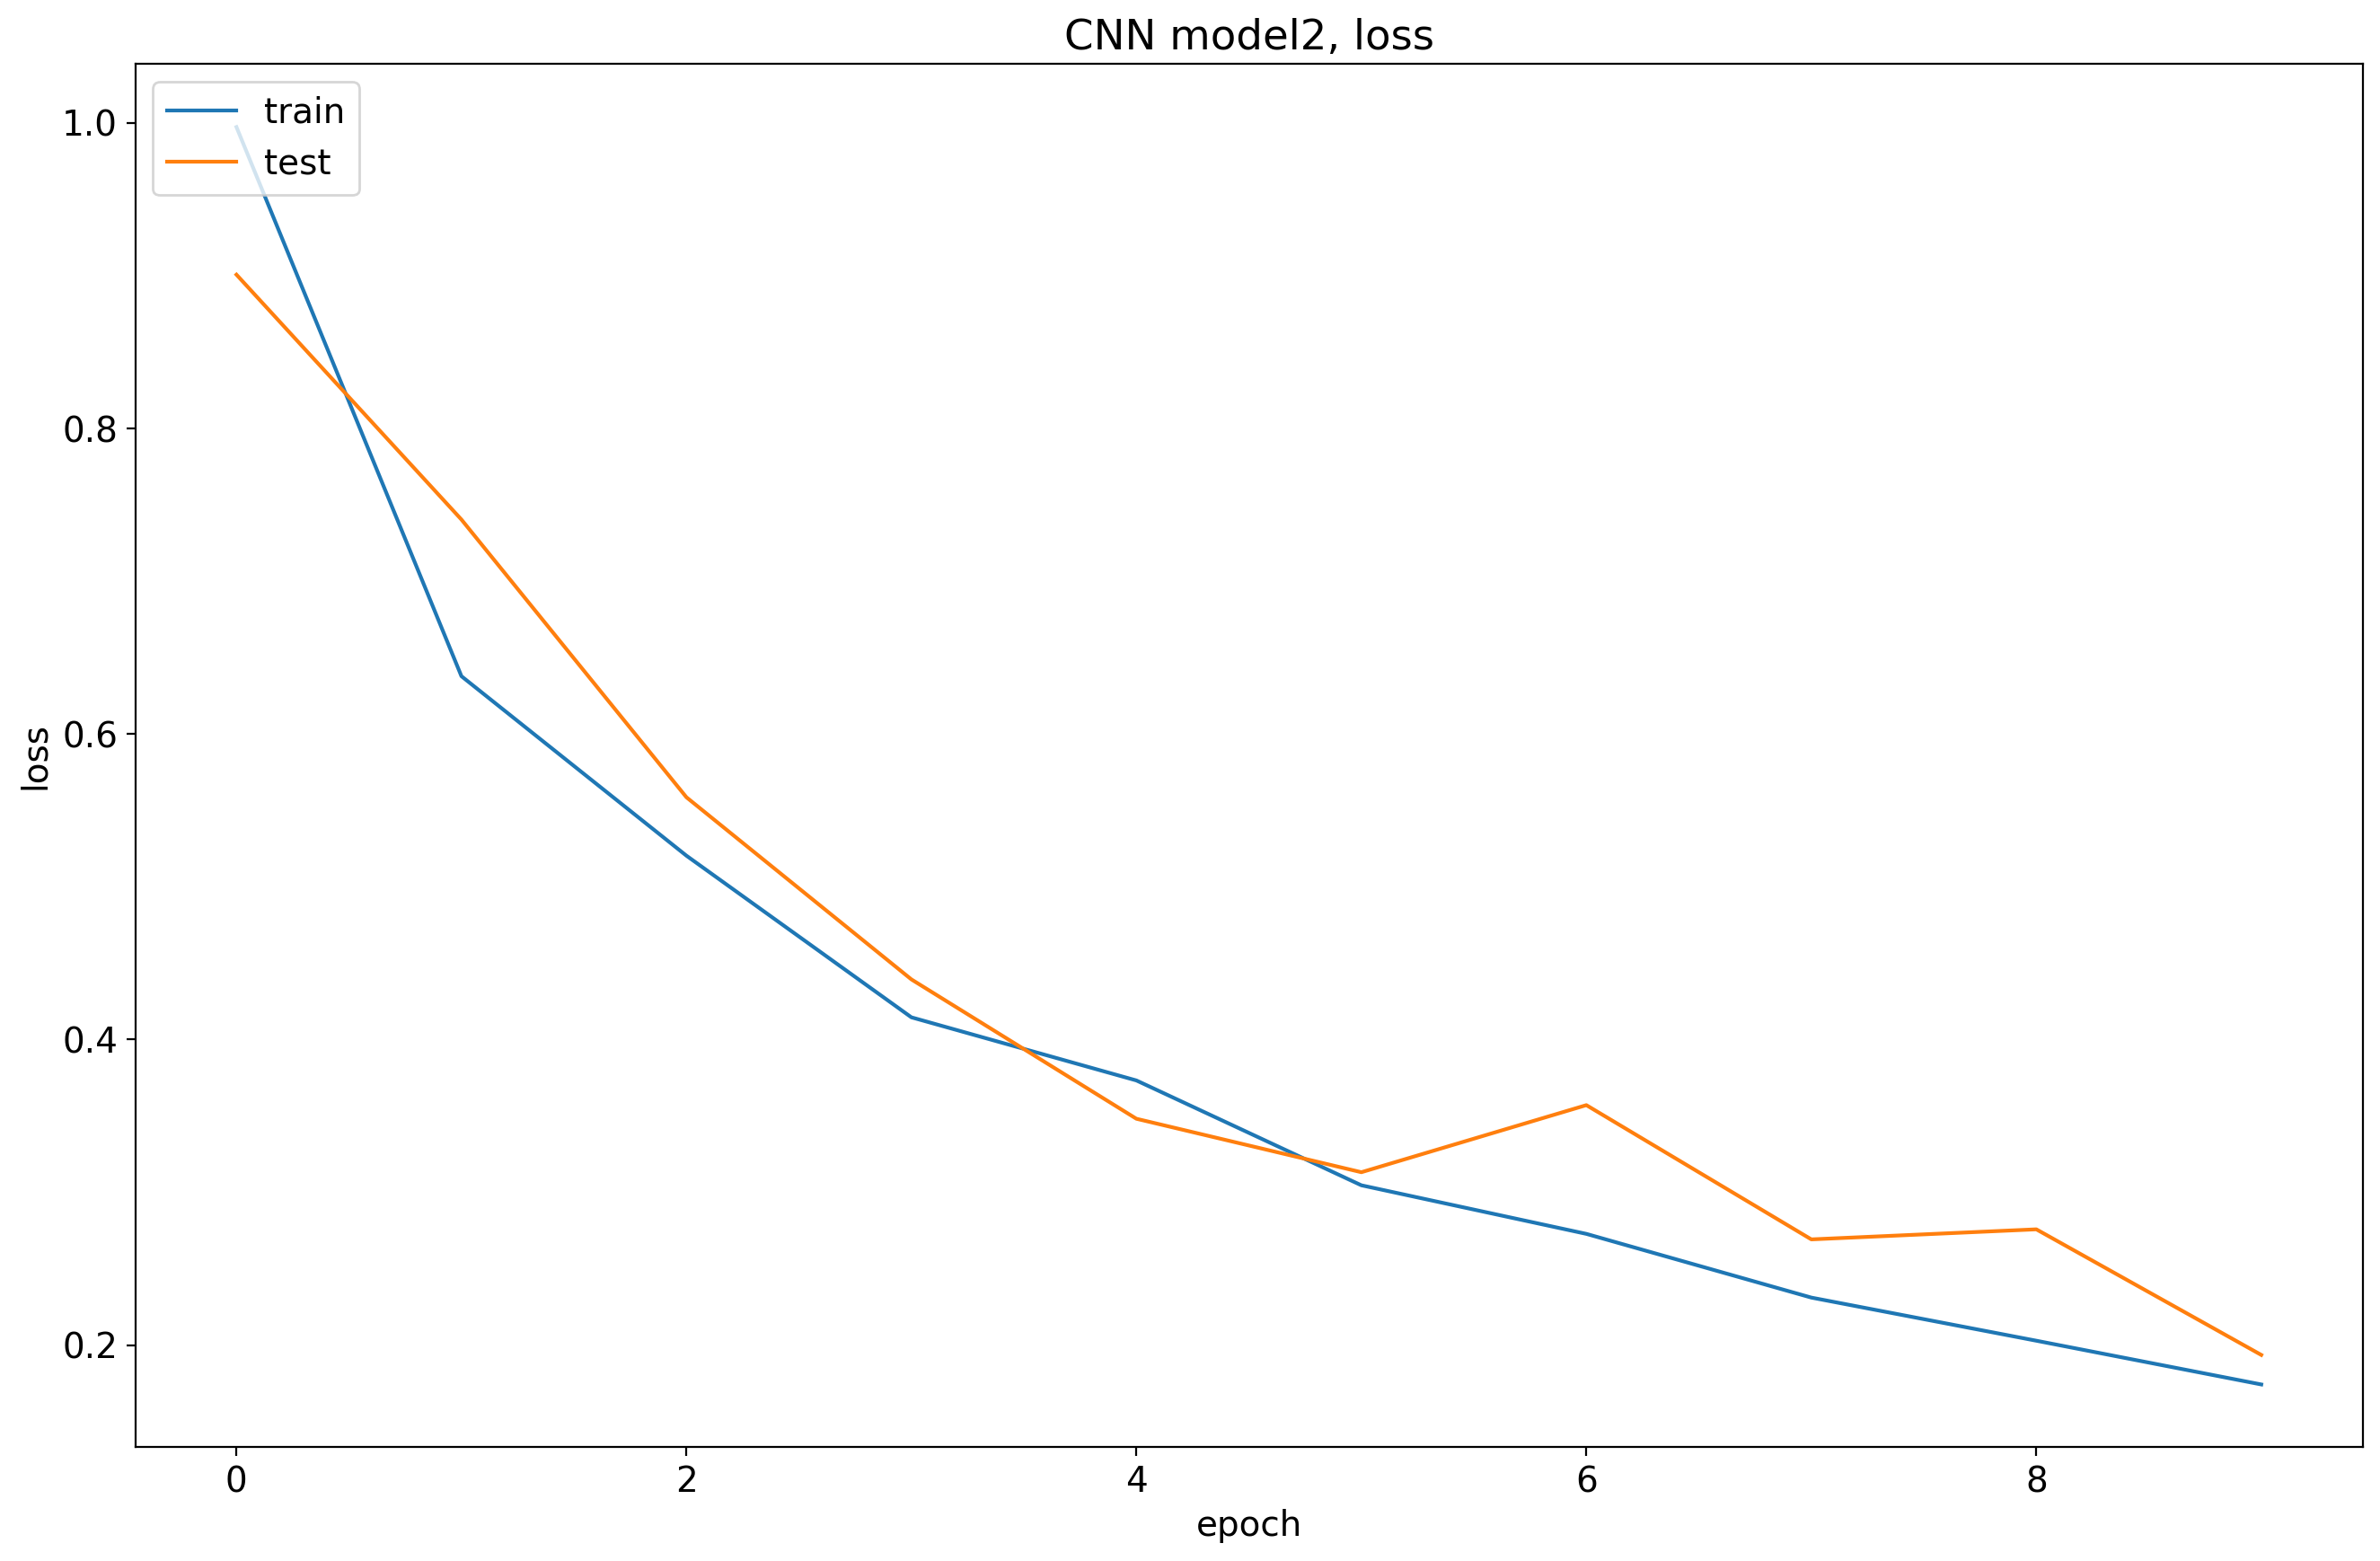

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('CNN model2, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 6s 105ms/step - loss: 0.1936 - accuracy: 0.9245
Train Loss: 0.1219
Train Accuracy: 95.64%
--------------------
Validation Loss: 0.1936
Validation Accuracy: 92.45%


### №3

filter_size = (3, 3)<br>
pool_size = (3, 3)

In [ ]:
model3 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model3.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist3 = model3.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
179/179 [==============================] - 49s 240ms/step - loss: 0.9671 - accuracy: 0.5839 - val_loss: 0.8677 - val_accuracy: 0.6560
Epoch 2/10
179/179 [==============================] - 43s 235ms/step - loss: 0.6482 - accuracy: 0.7495 - val_loss: 0.5868 - val_accuracy: 0.7666
Epoch 3/10
179/179 [==============================] - 45s 248ms/step - loss: 0.5509 - accuracy: 0.7850 - val_loss: 0.5608 - val_accuracy: 0.7727
Epoch 4/10
179/179 [==============================] - 44s 240ms/step - loss: 0.4435 - accuracy: 0.8311 - val_loss: 0.4474 - val_accuracy: 0.8116
Epoch 5/10
179/179 [==============================] - 43s 236ms/step - loss: 0.3514 - accuracy: 0.8673 - val_loss: 0.3637 - val_accuracy: 0.8520
Epoch 6/10
179/179 [==============================] - 43s 234ms/step - loss: 0.2982 - accuracy: 0.8859 - val_loss: 0.2963 - val_accuracy: 0.8924
Epoch 7/10
179/179 [==============================] - 44s 239ms/step - loss: 0.2650 - accuracy: 0.9025 - val_loss: 0.2906 - val_ac

Збереження моделі:

In [ ]:
model3.save('/content/drive/MyDrive/brain-tumor-models/model3')

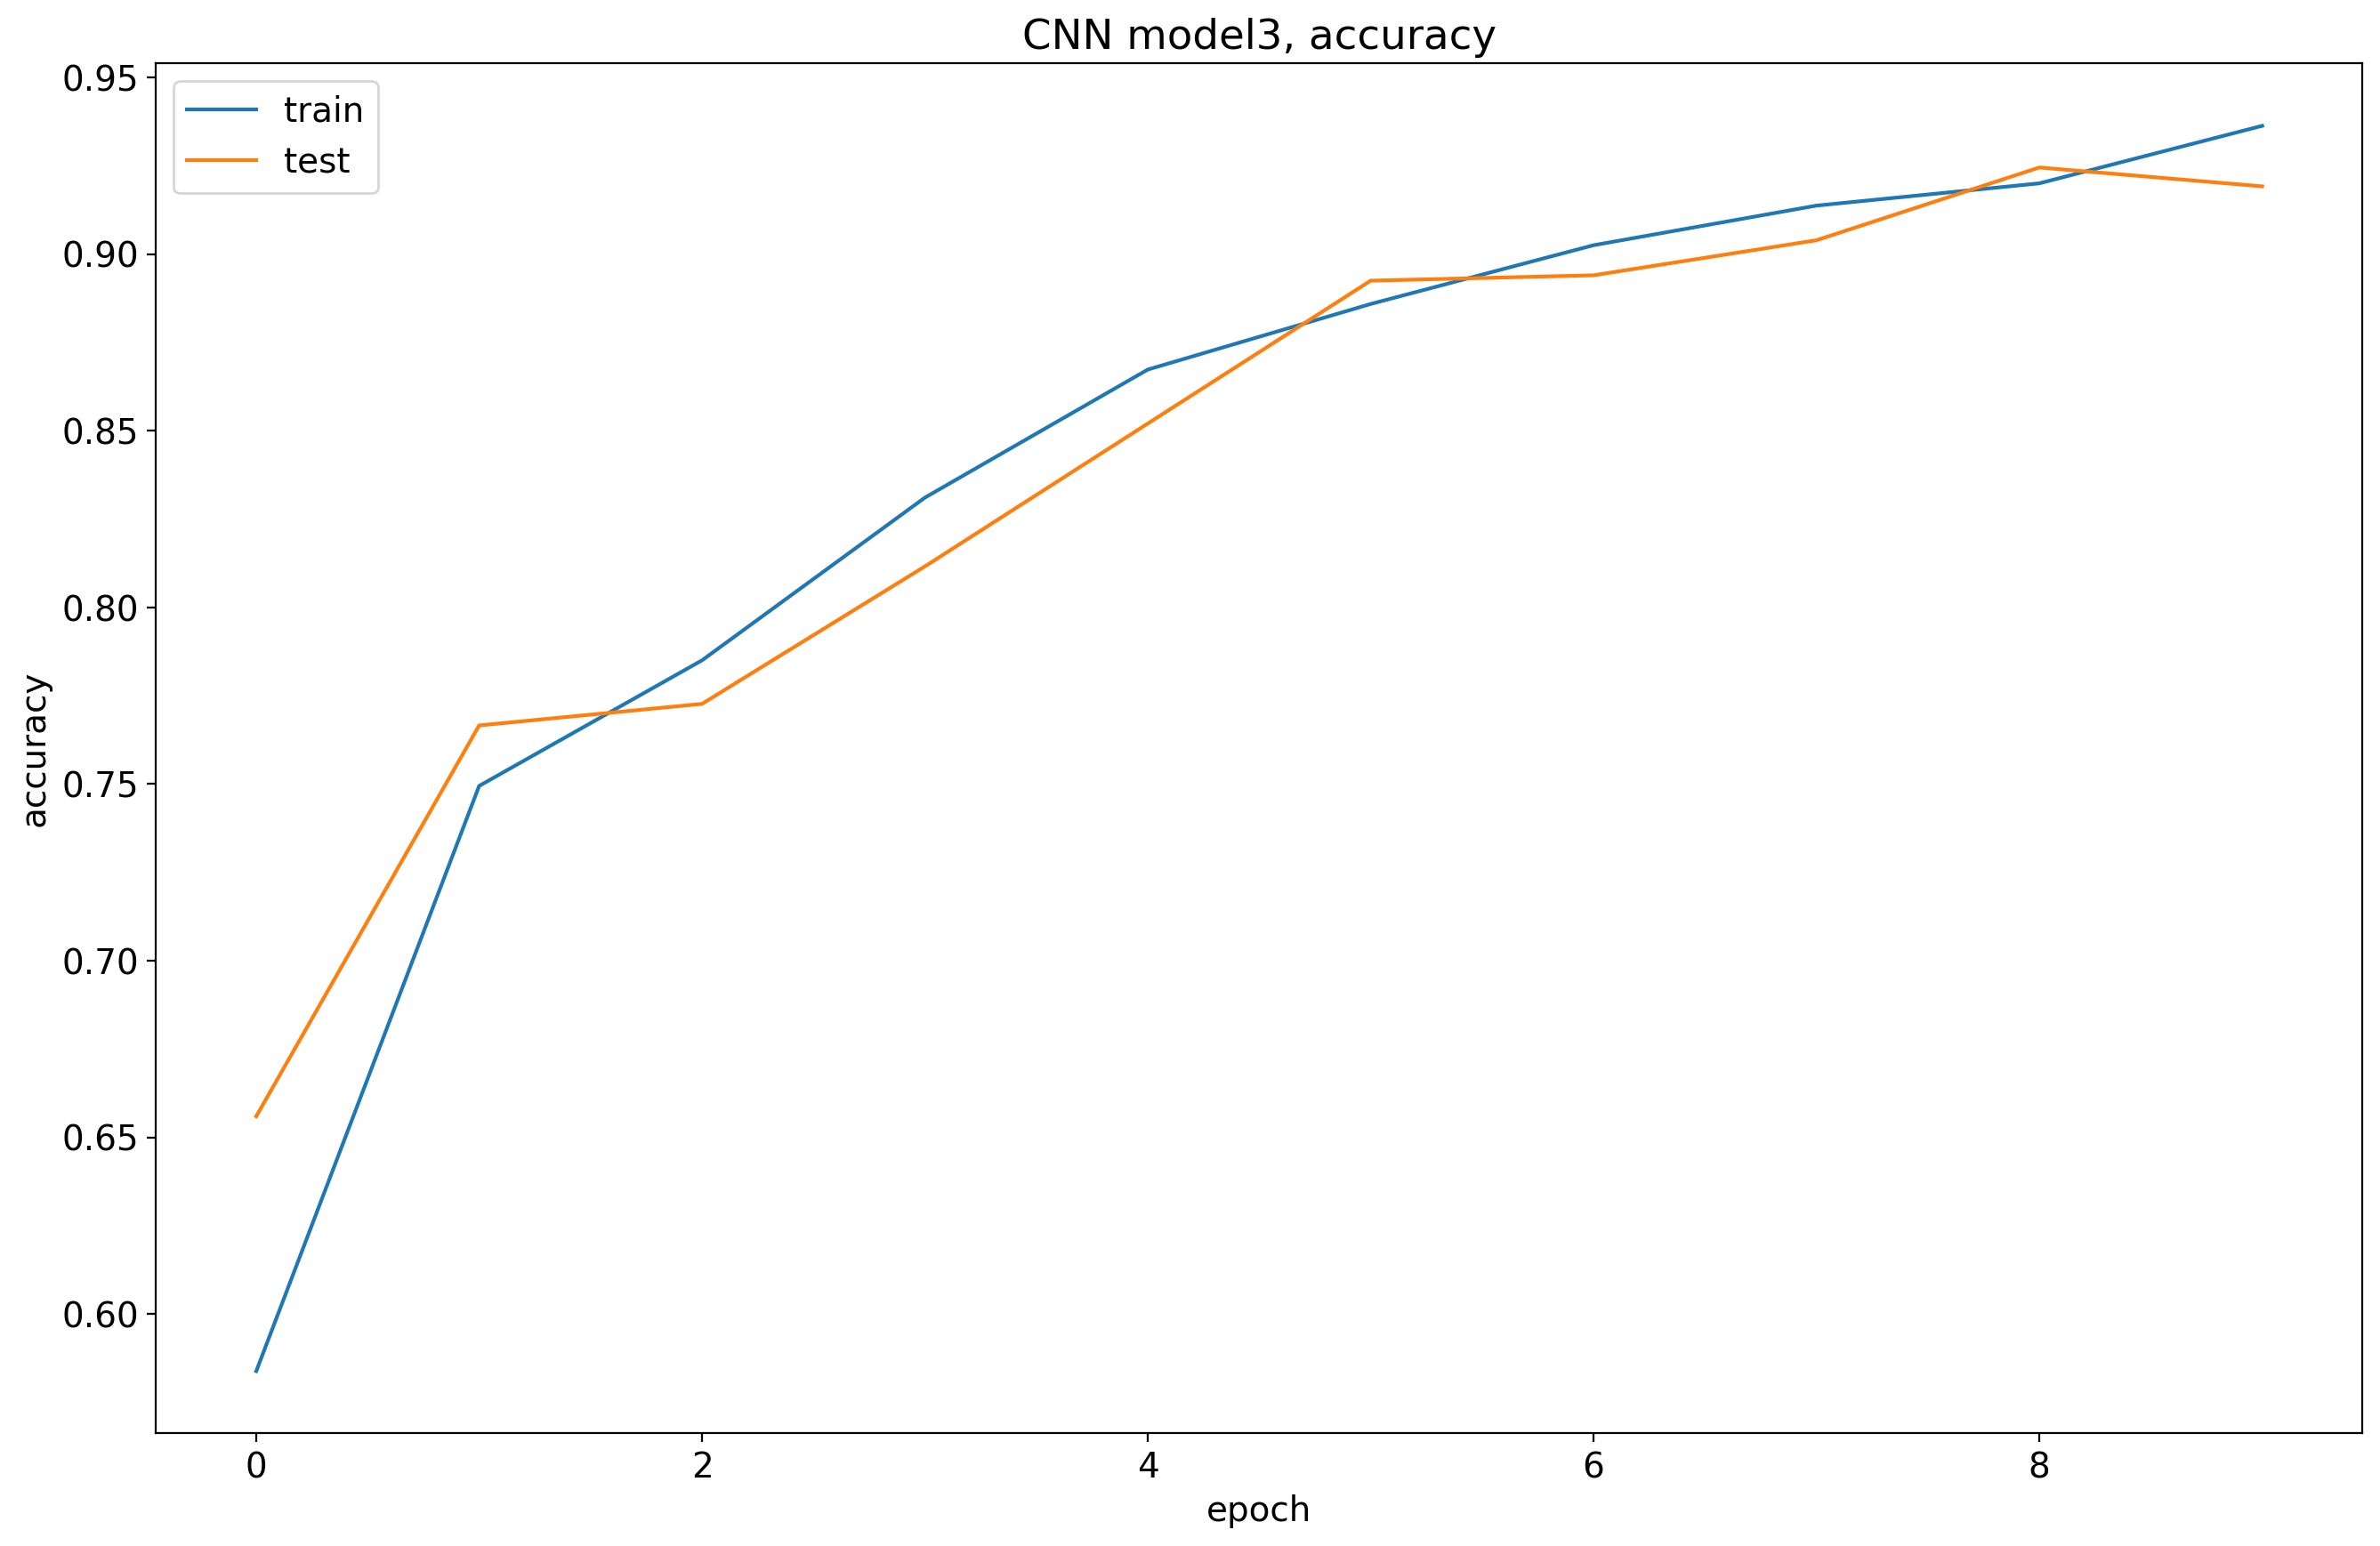

In [ ]:
# графік навчання, точність моделі
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('CNN model3, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

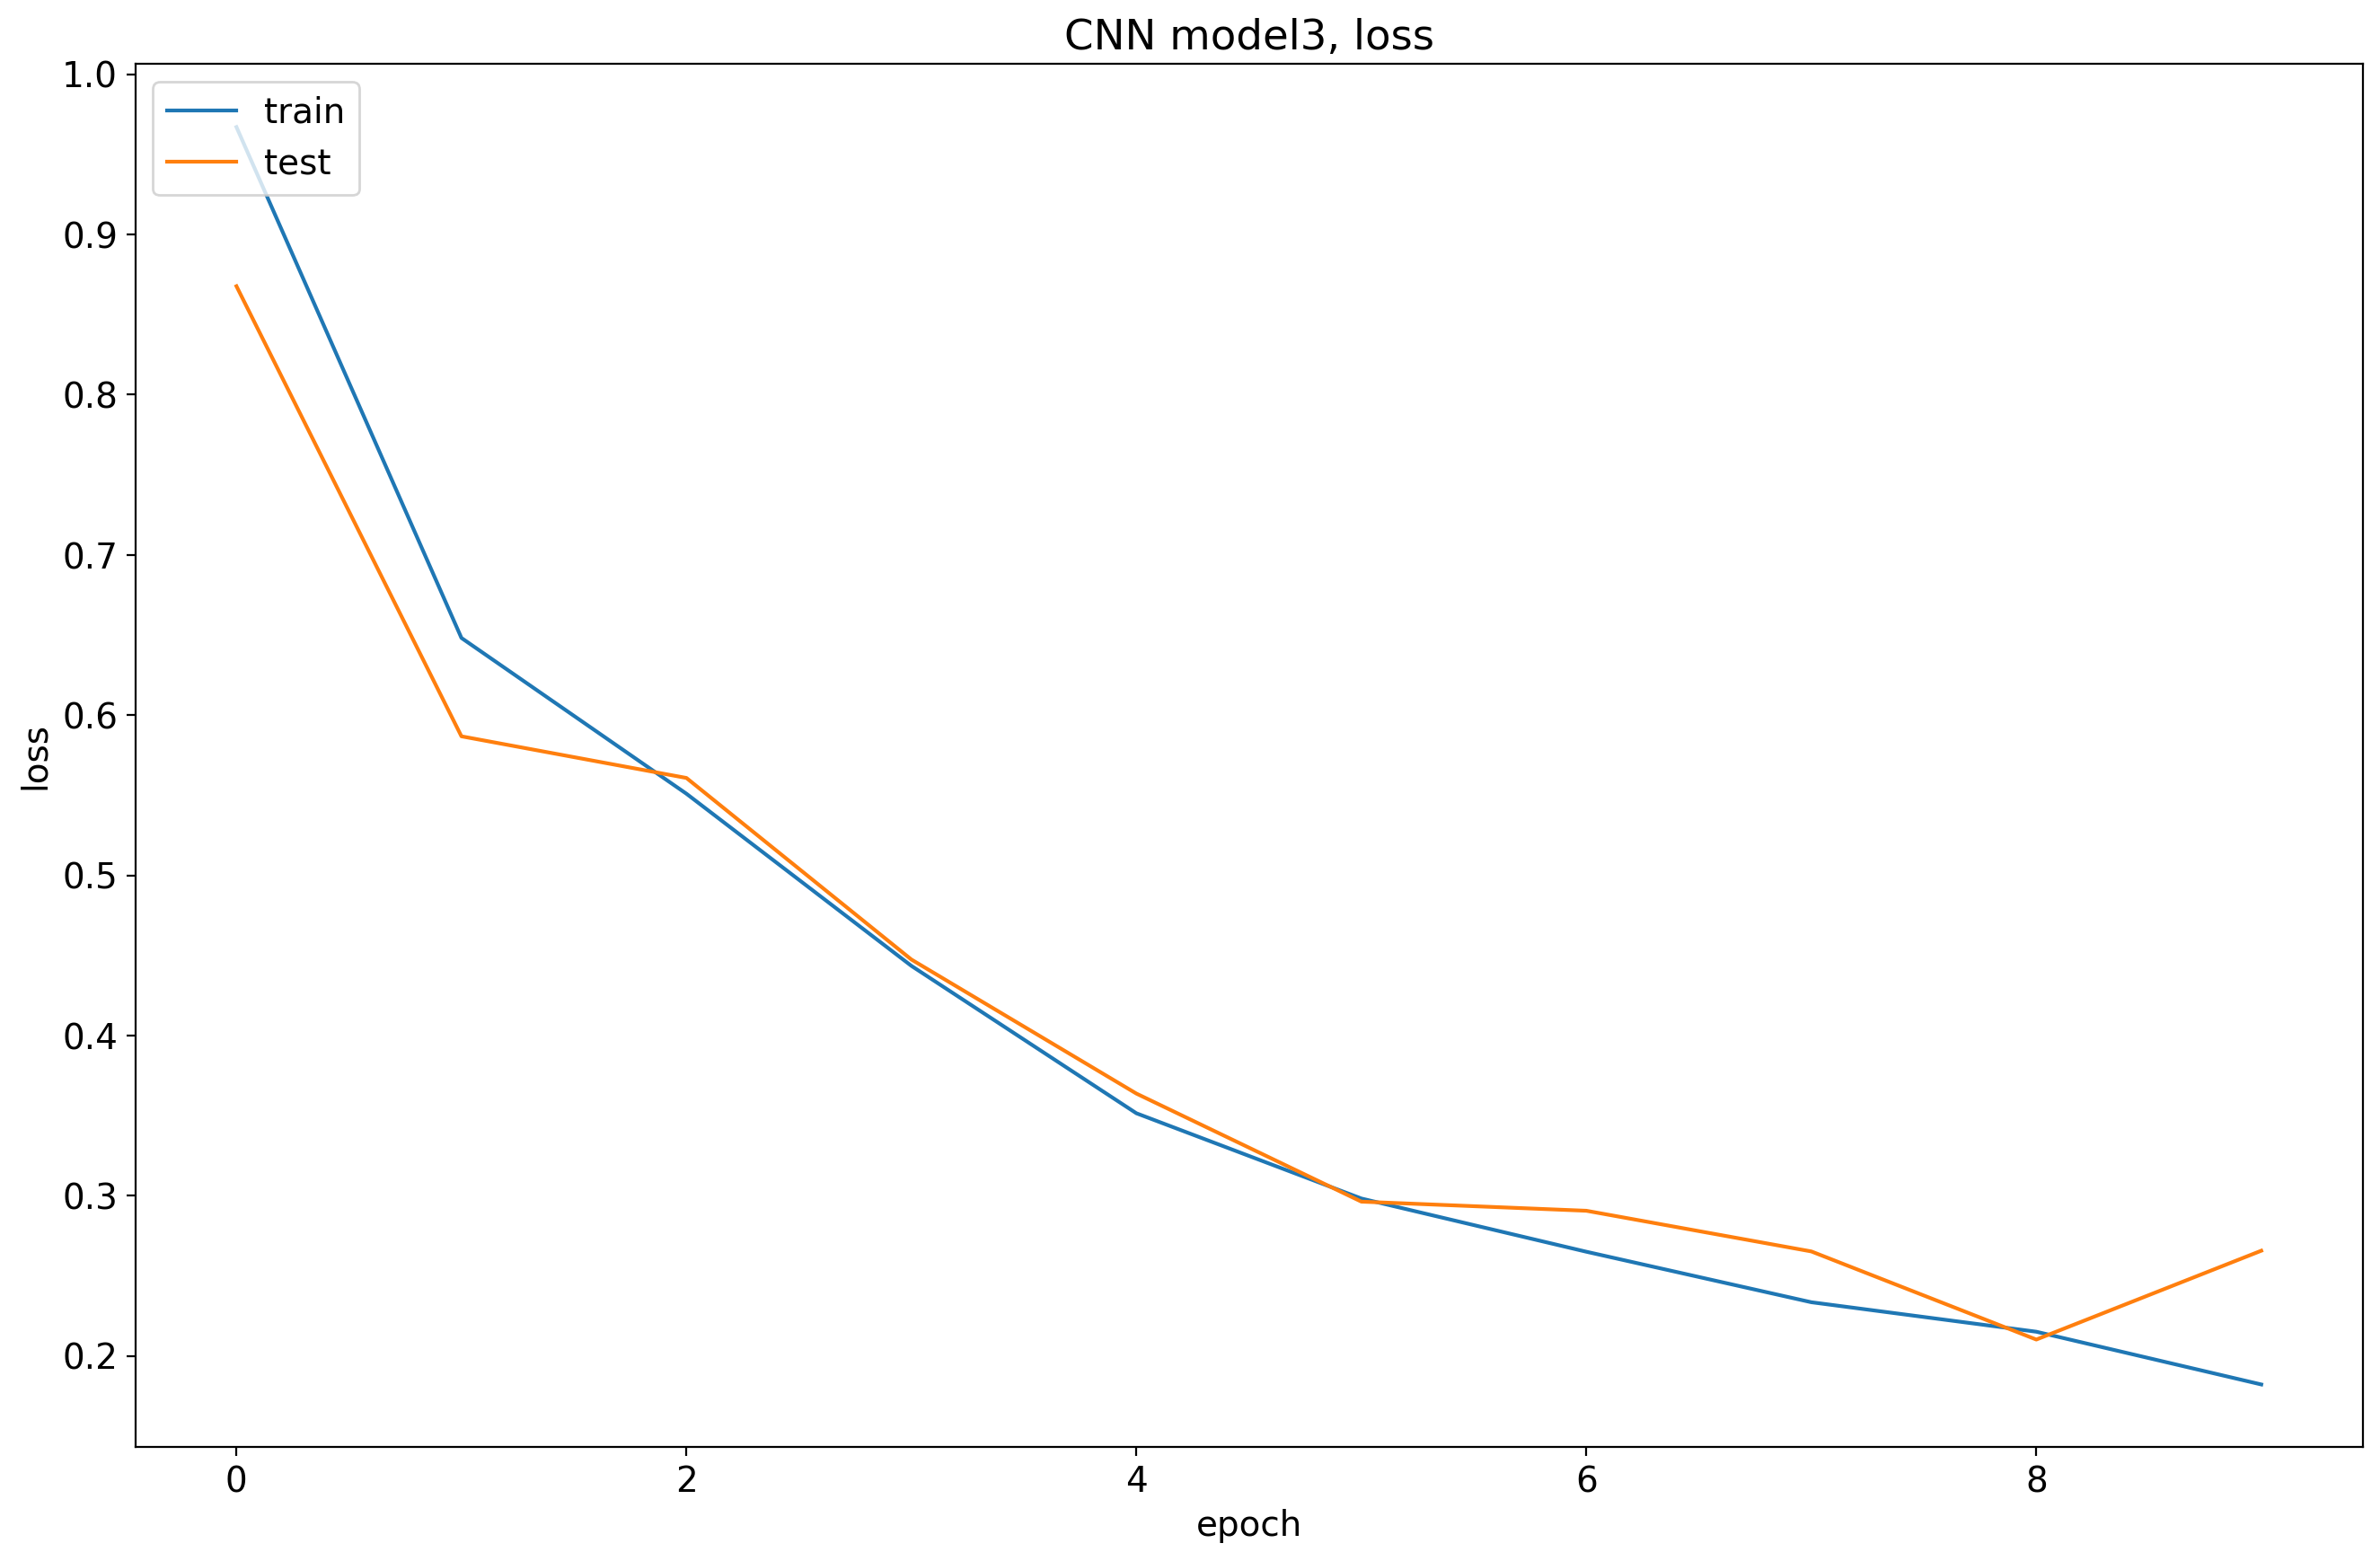

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('CNN model3, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model3.evaluate(train_ds, verbose=1)
valid_score = model3.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 101ms/step - loss: 0.2656 - accuracy: 0.9191
Train Loss: 0.1394
Train Accuracy: 95.17%
--------------------
Validation Loss: 0.2656
Validation Accuracy: 91.91%


### №4

filter_size = (3, 3)<br>
pool_size = (2, 2)

In [ ]:
model4 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 3, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.3, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model4.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist4 = model4.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
179/179 [==============================] - 46s 242ms/step - loss: 0.9617 - accuracy: 0.5940 - val_loss: 0.8132 - val_accuracy: 0.6690
Epoch 2/10
179/179 [==============================] - 43s 235ms/step - loss: 0.6143 - accuracy: 0.7598 - val_loss: 0.6601 - val_accuracy: 0.7346
Epoch 3/10
179/179 [==============================] - 44s 240ms/step - loss: 0.5115 - accuracy: 0.8029 - val_loss: 0.5467 - val_accuracy: 0.7872
Epoch 4/10
179/179 [==============================] - 43s 234ms/step - loss: 0.4406 - accuracy: 0.8276 - val_loss: 0.5038 - val_accuracy: 0.8032
Epoch 5/10
179/179 [==============================] - 45s 247ms/step - loss: 0.3768 - accuracy: 0.8542 - val_loss: 0.4756 - val_accuracy: 0.8177
Epoch 6/10
179/179 [==============================] - 42s 230ms/step - loss: 0.3189 - accuracy: 0.8817 - val_loss: 0.4105 - val_accuracy: 0.8459
Epoch 7/10
179/179 [==============================] - 43s 233ms/step - loss: 0.2968 - accuracy: 0.8901 - val_loss: 0.4140 - val_ac

Збереження моделі:

In [ ]:
model4.save('/content/drive/MyDrive/brain-tumor-models/model4')

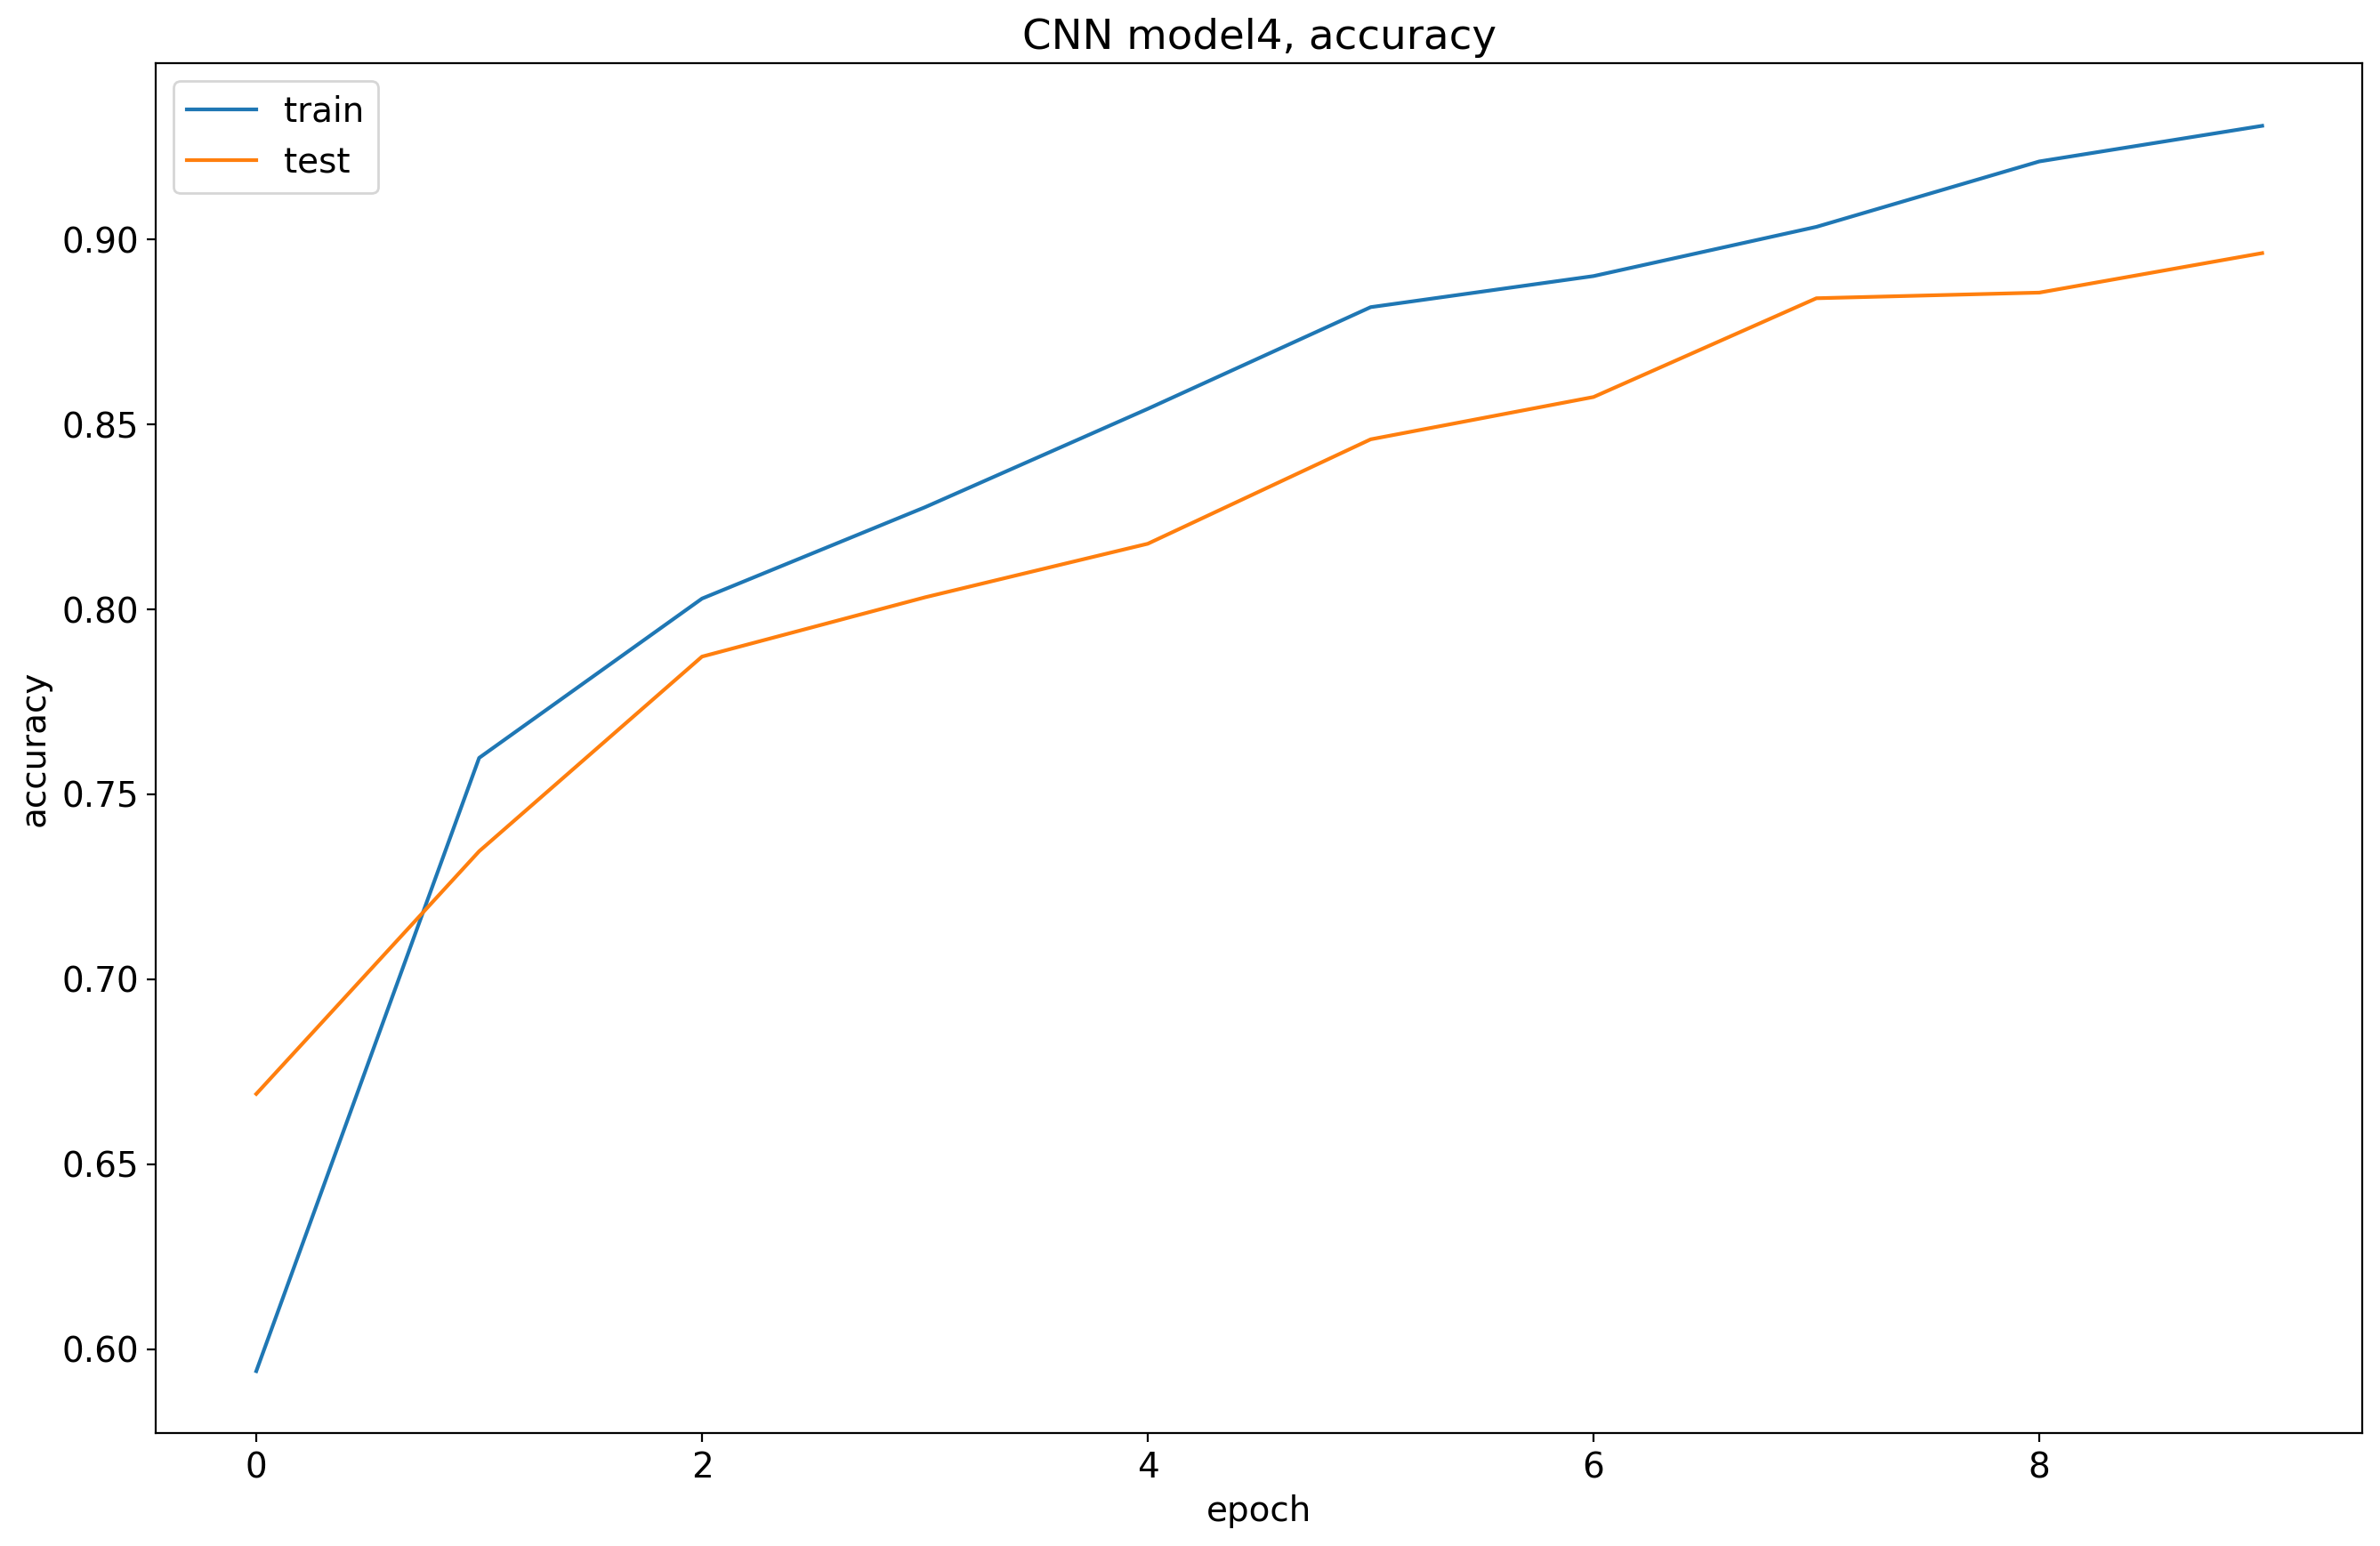

In [ ]:
# графік навчання, точність моделі
plt.plot(hist4.history['accuracy'])
plt.plot(hist4.history['val_accuracy'])
plt.title('CNN model4, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

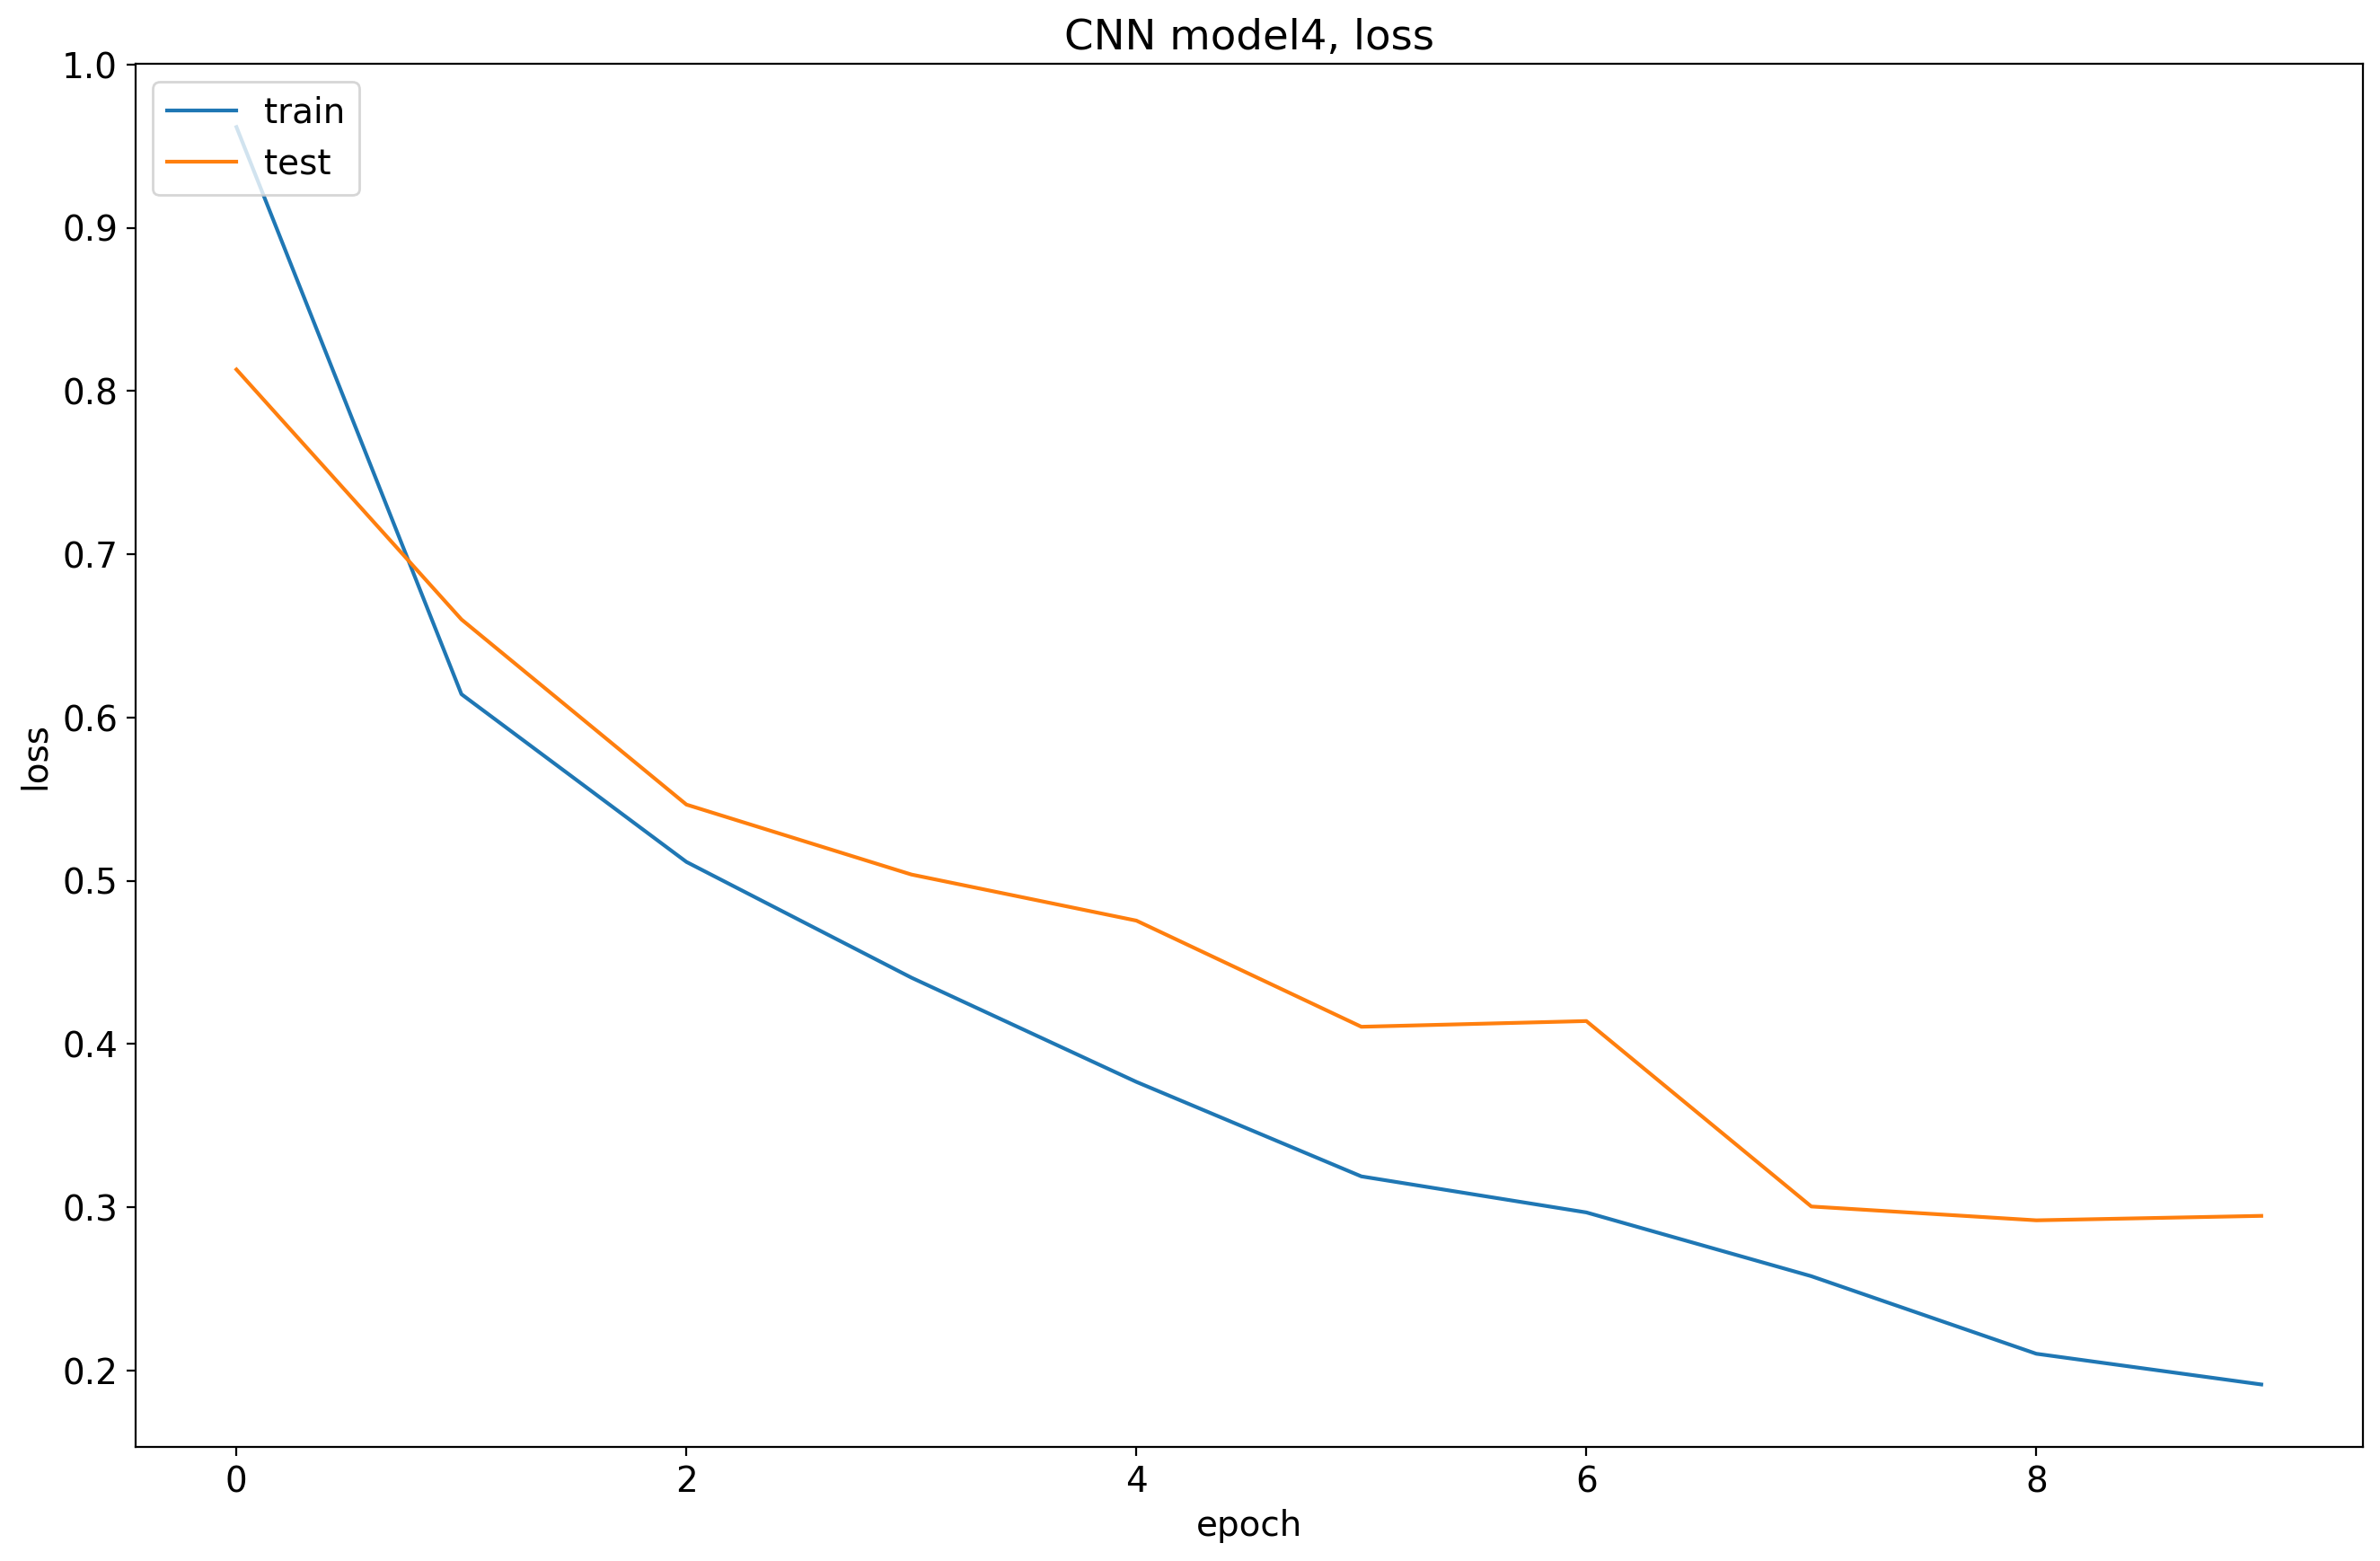

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist4.history['loss'])
plt.plot(hist4.history['val_loss'])
plt.title('CNN model4, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model4.evaluate(train_ds, verbose=1)
valid_score = model4.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 95ms/step - loss: 0.2947 - accuracy: 0.8963
Train Loss: 0.1834
Train Accuracy: 93.91%
--------------------
Validation Loss: 0.2947
Validation Accuracy: 89.63%


## Моделі з різним оптимізатором

### №1

2 згорткові шари

In [ ]:
model5 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model5.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist5 = model5.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2325

KeyboardInterrupt: 

Збереження моделі:

In [ ]:
model5.save('/content/drive/MyDrive/brain-tumor-models/model5')

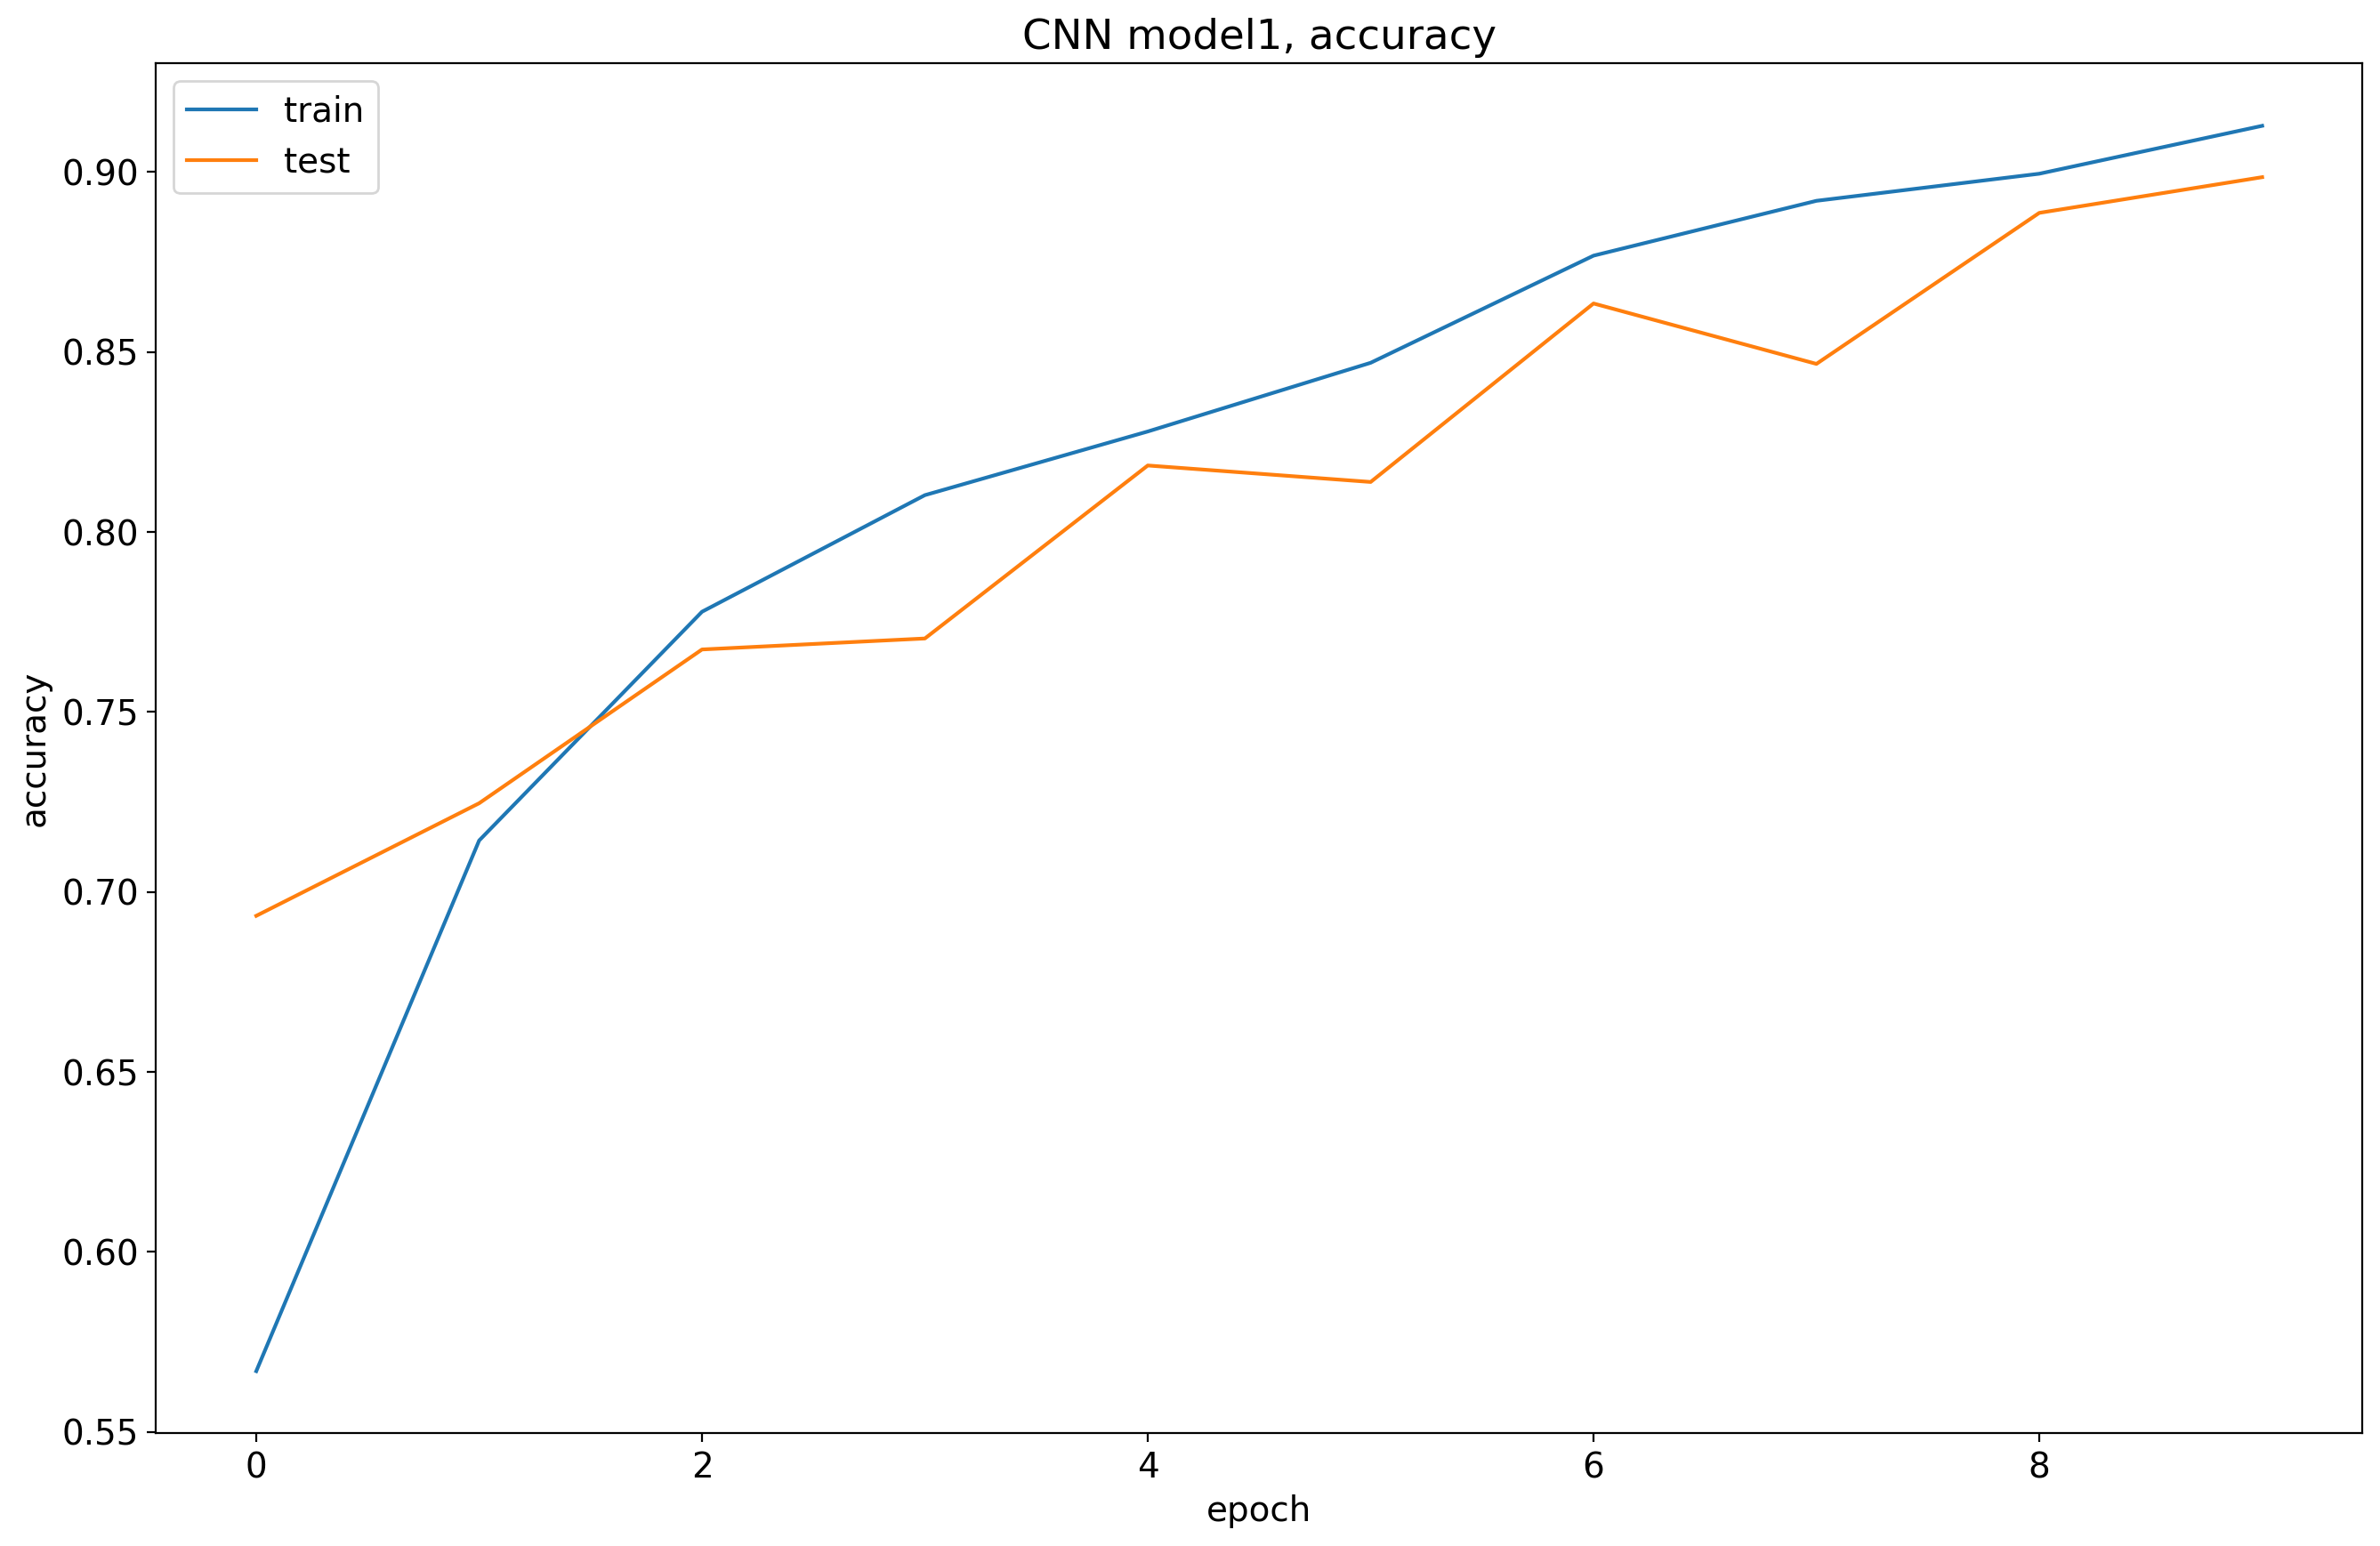

In [ ]:
# графік навчання, точність моделі
plt.plot(hist5.history['accuracy'])
plt.plot(hist5.history['val_accuracy'])
plt.title('CNN model (2 conv2D), accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

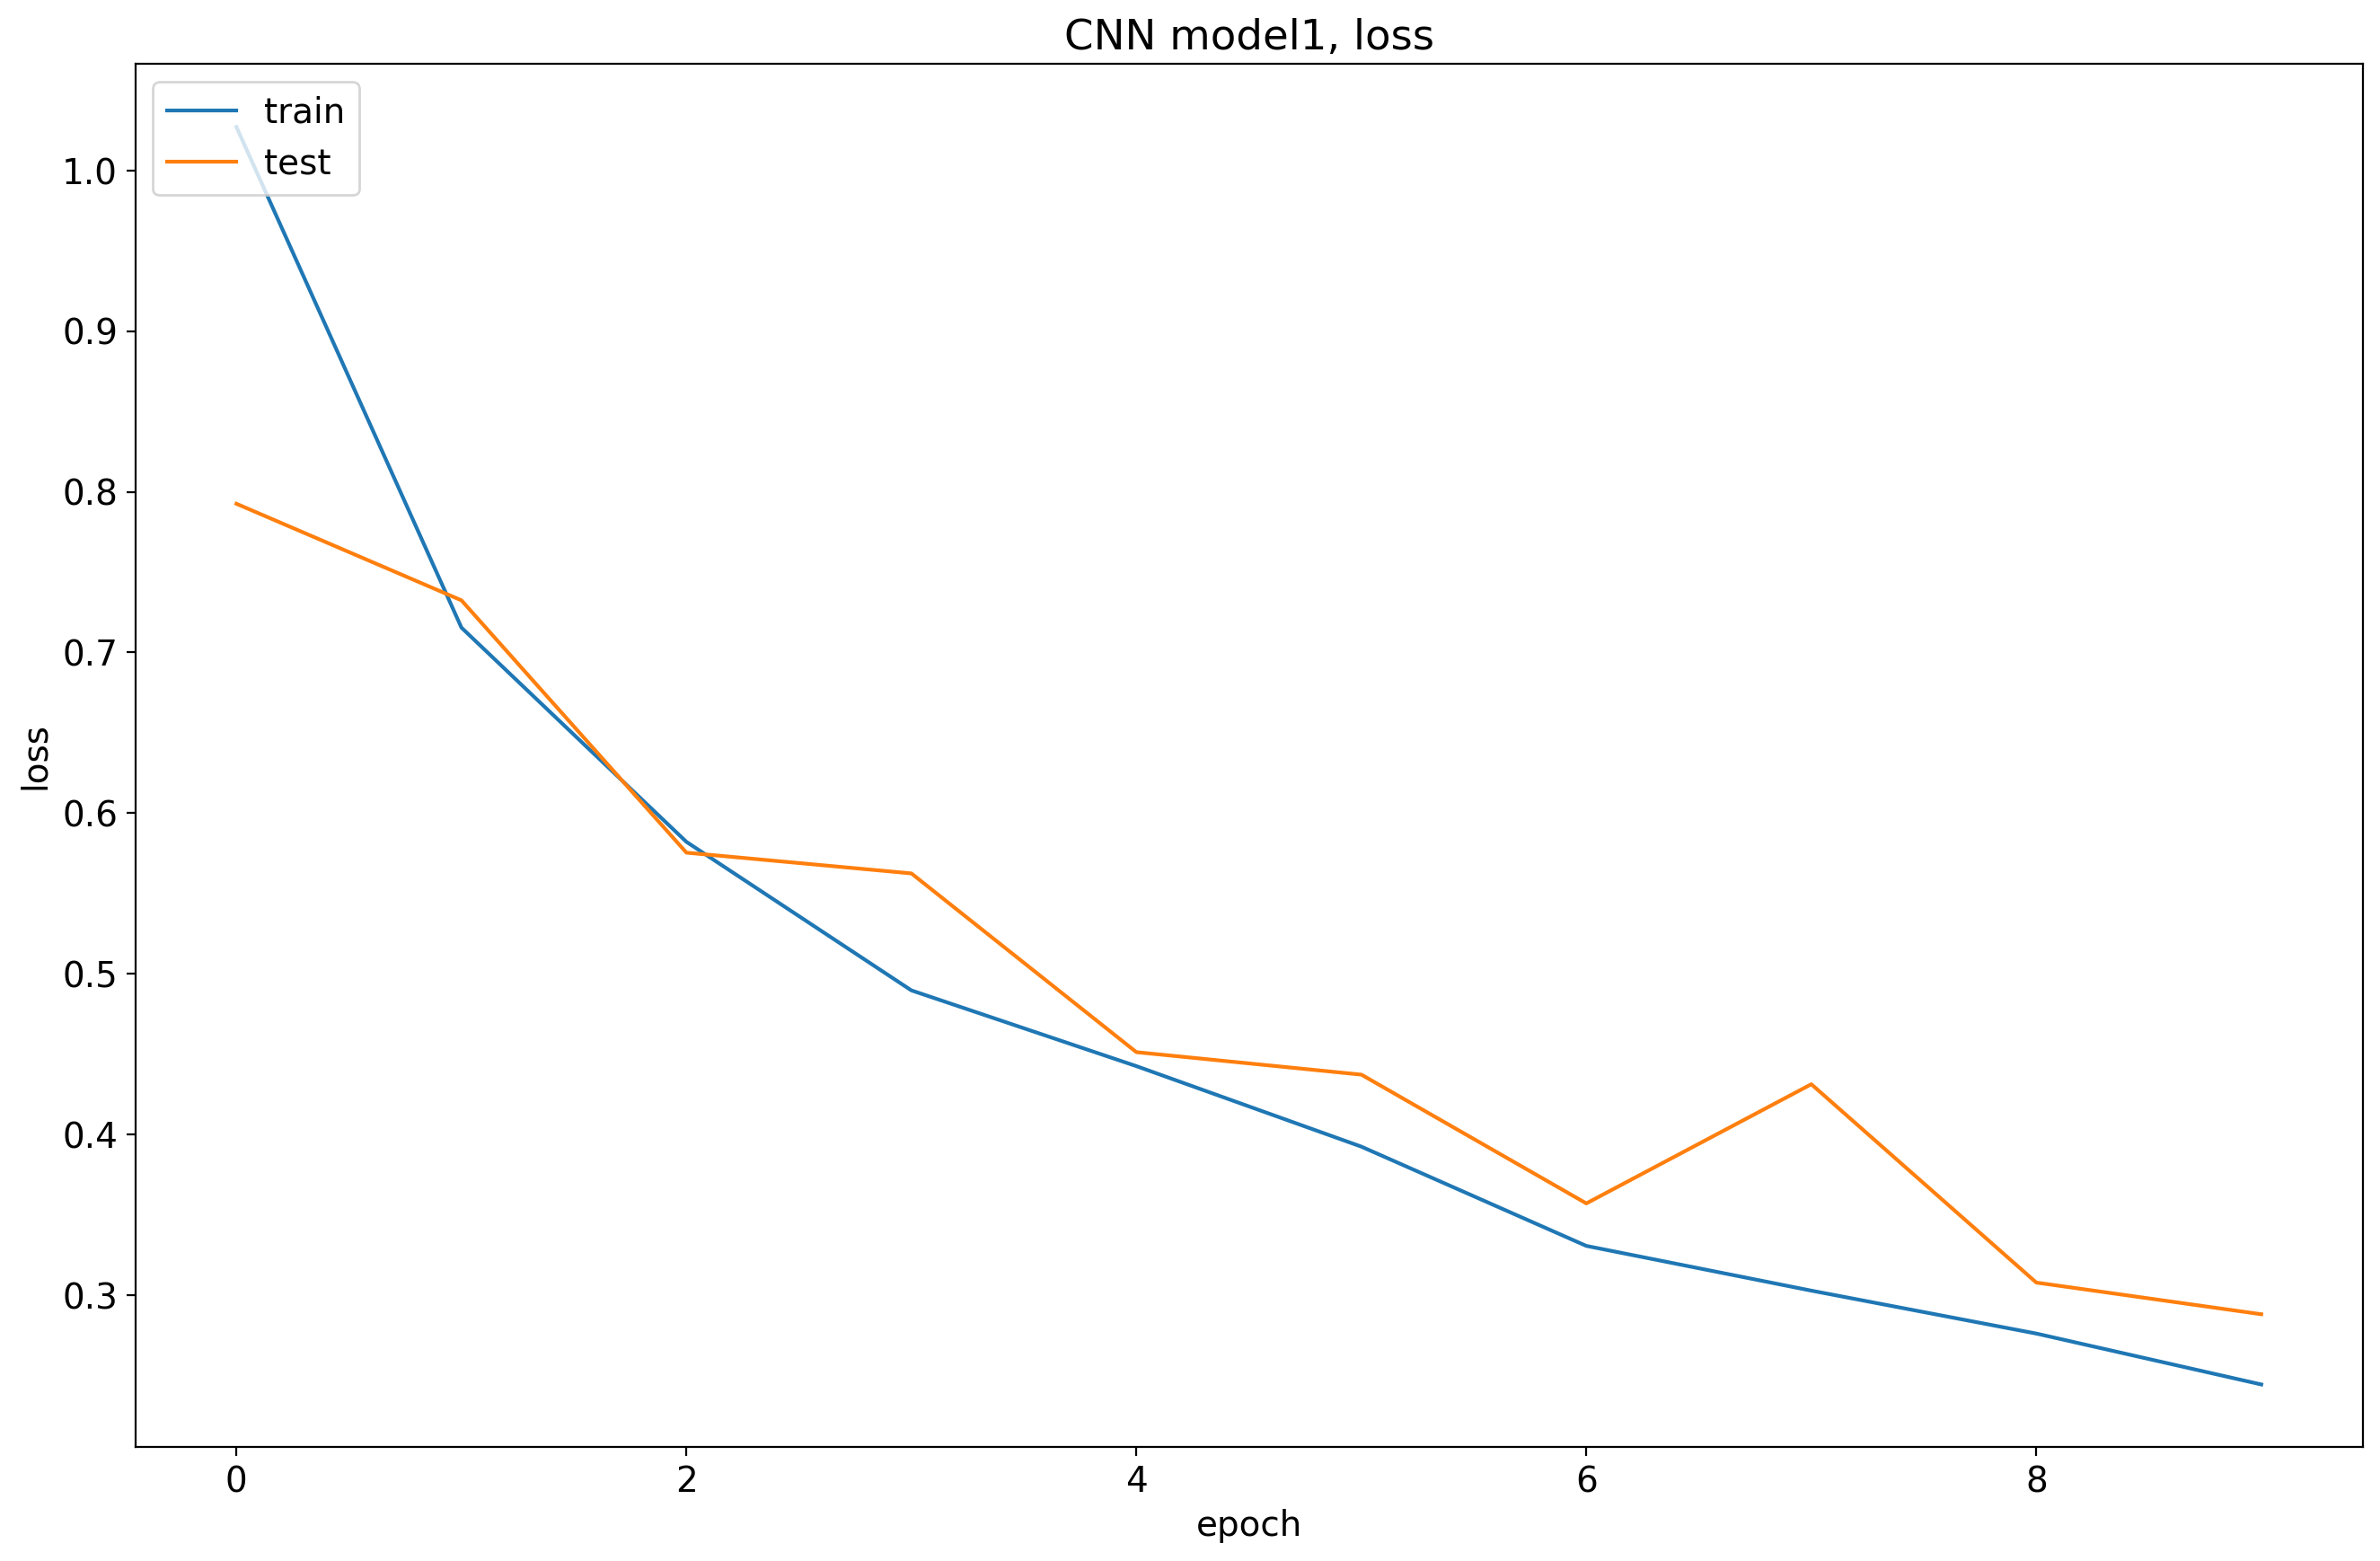

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist5.history['loss'])
plt.plot(hist5.history['val_loss'])
plt.title('CNN model (2 conv2D), loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model5.evaluate(train_ds, verbose=1)
valid_score = model5.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 106ms/step - loss: 0.2880 - accuracy: 0.8986
Train Loss: 0.1873
Train Accuracy: 92.61%
--------------------
Validation Loss: 0.2880
Validation Accuracy: 89.86%


### №2

3 згорткові шари

In [ ]:
model6 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, (4, 4), activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model6.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist6 = model6.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
 33/179 [====>.........................] - ETA: 7:01 - loss: nan - accuracy: 0.2197

Збереження моделі:

In [ ]:
model6.save('/content/drive/MyDrive/brain-tumor-models/model6')

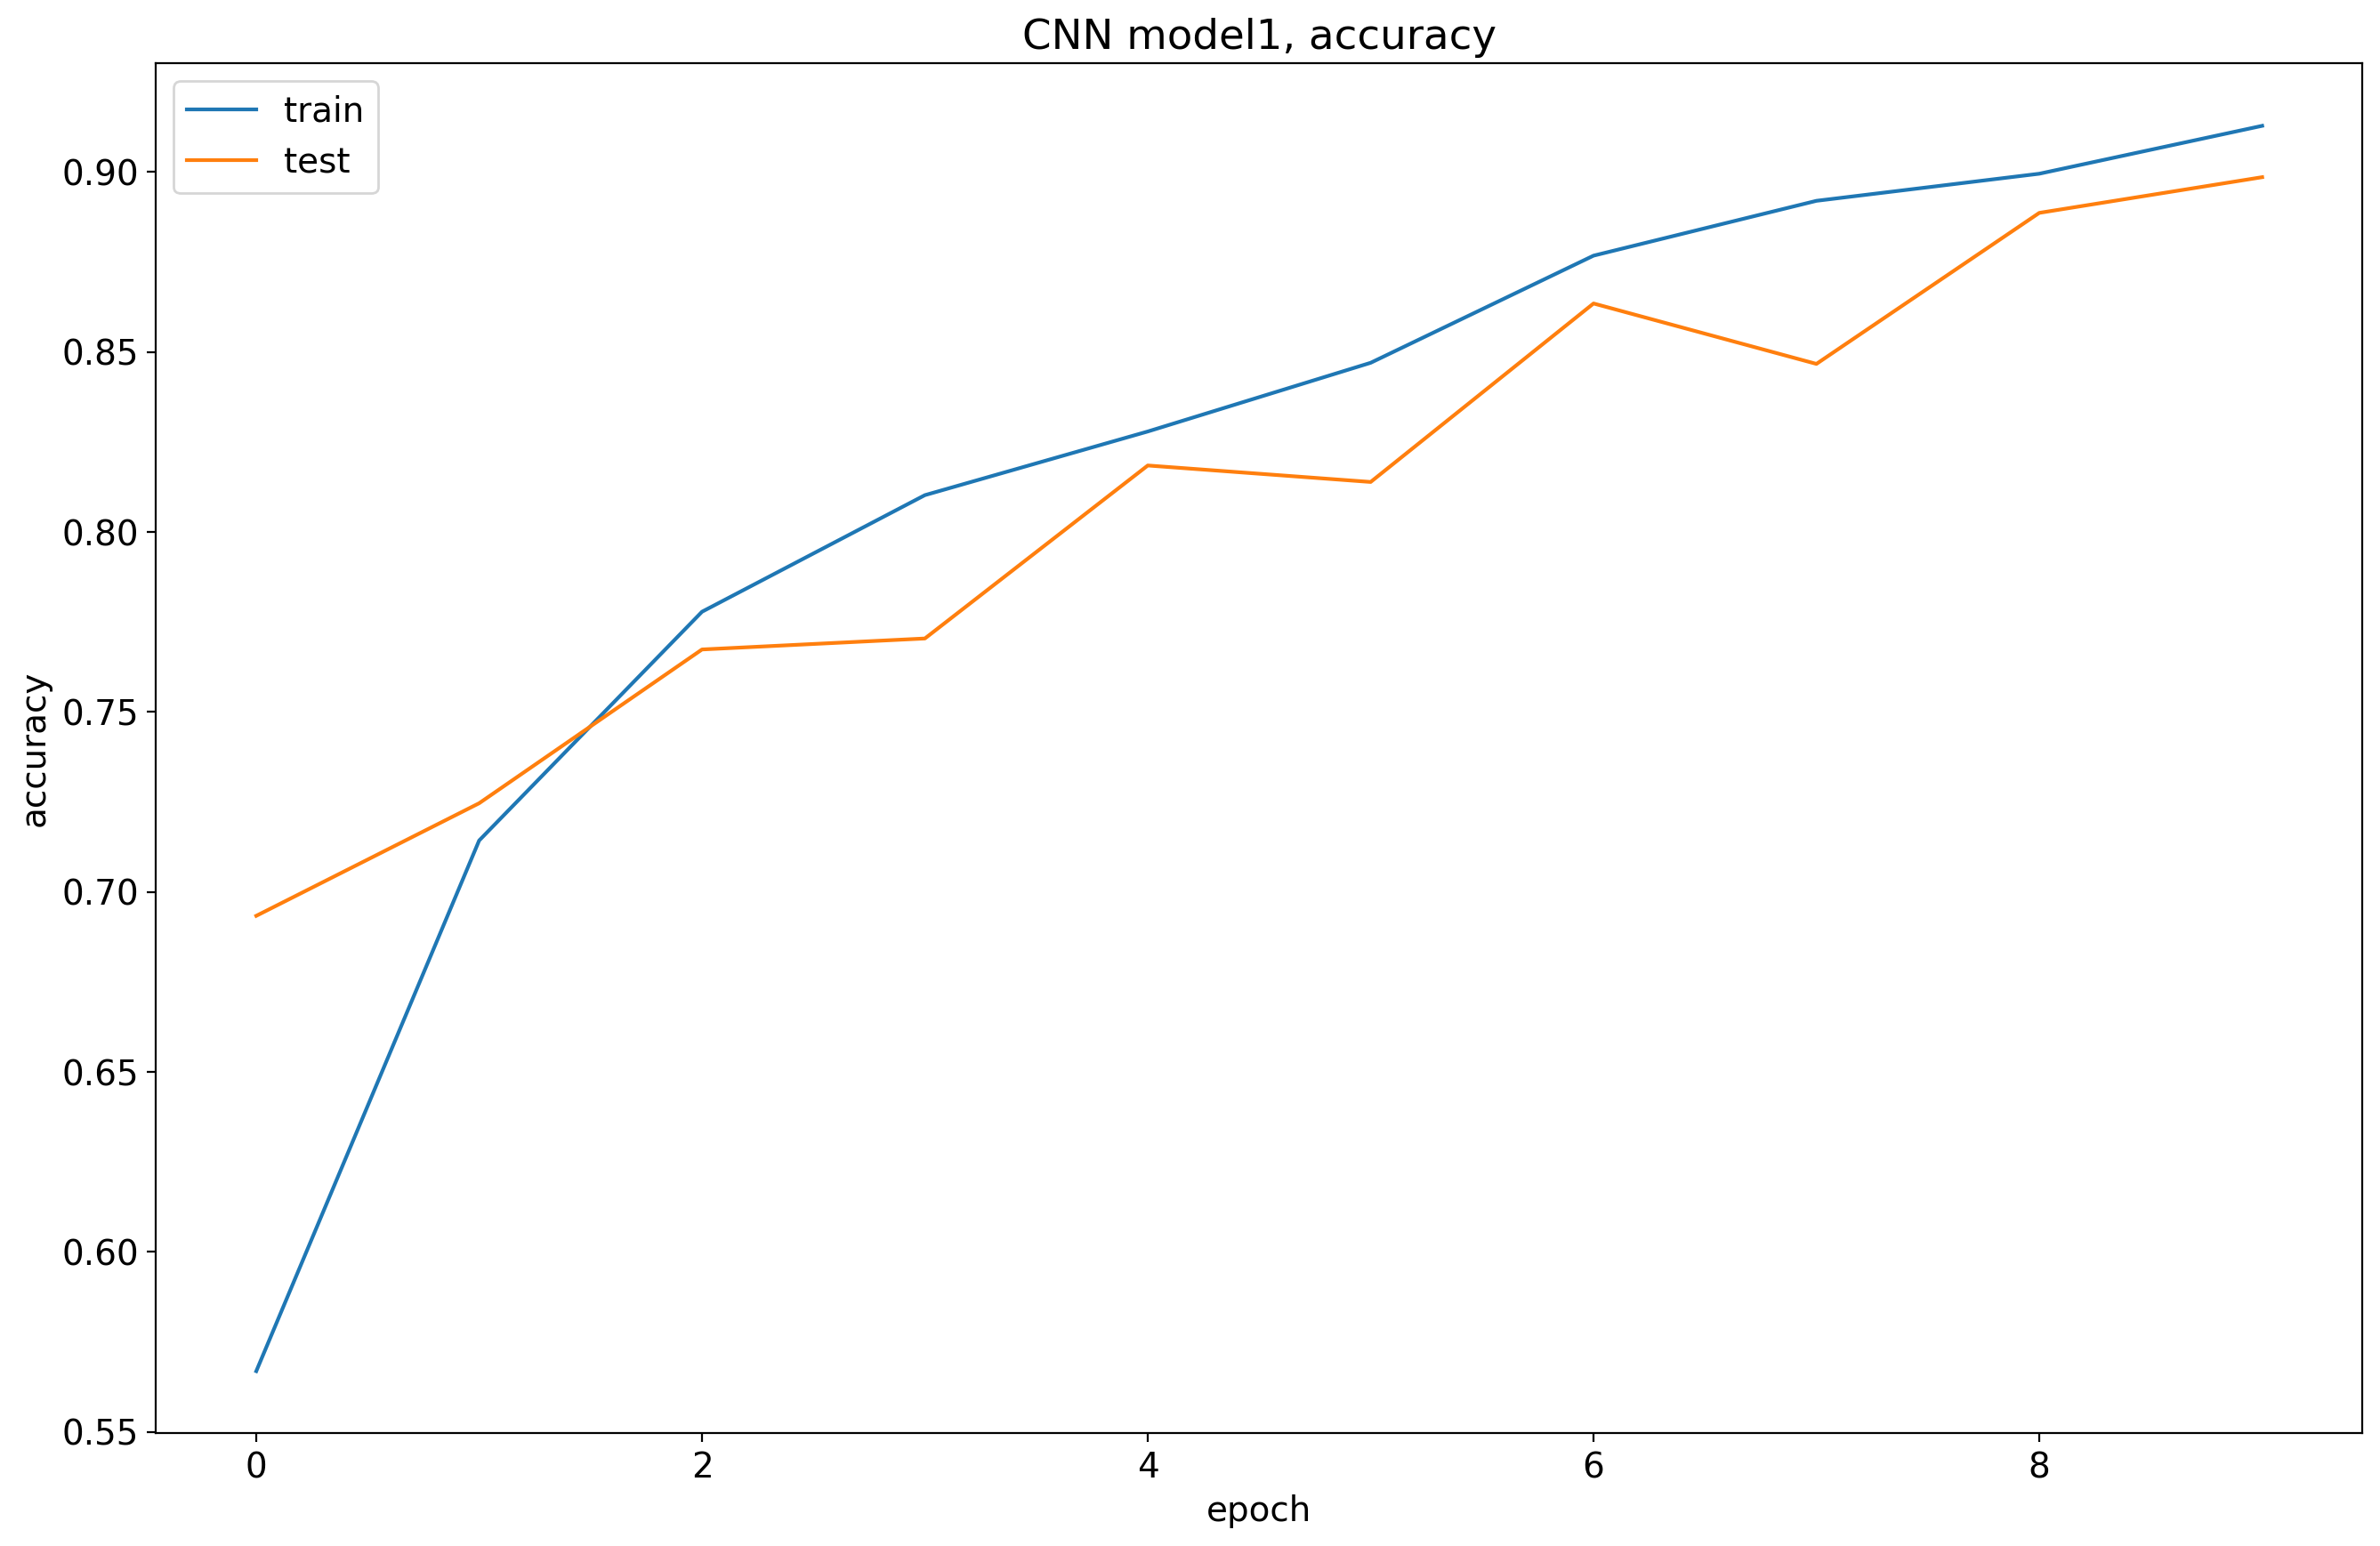

In [ ]:
# графік навчання, точність моделі
plt.plot(hist6.history['accuracy'])
plt.plot(hist6.history['val_accuracy'])
plt.title('CNN model (3 conv2D), accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

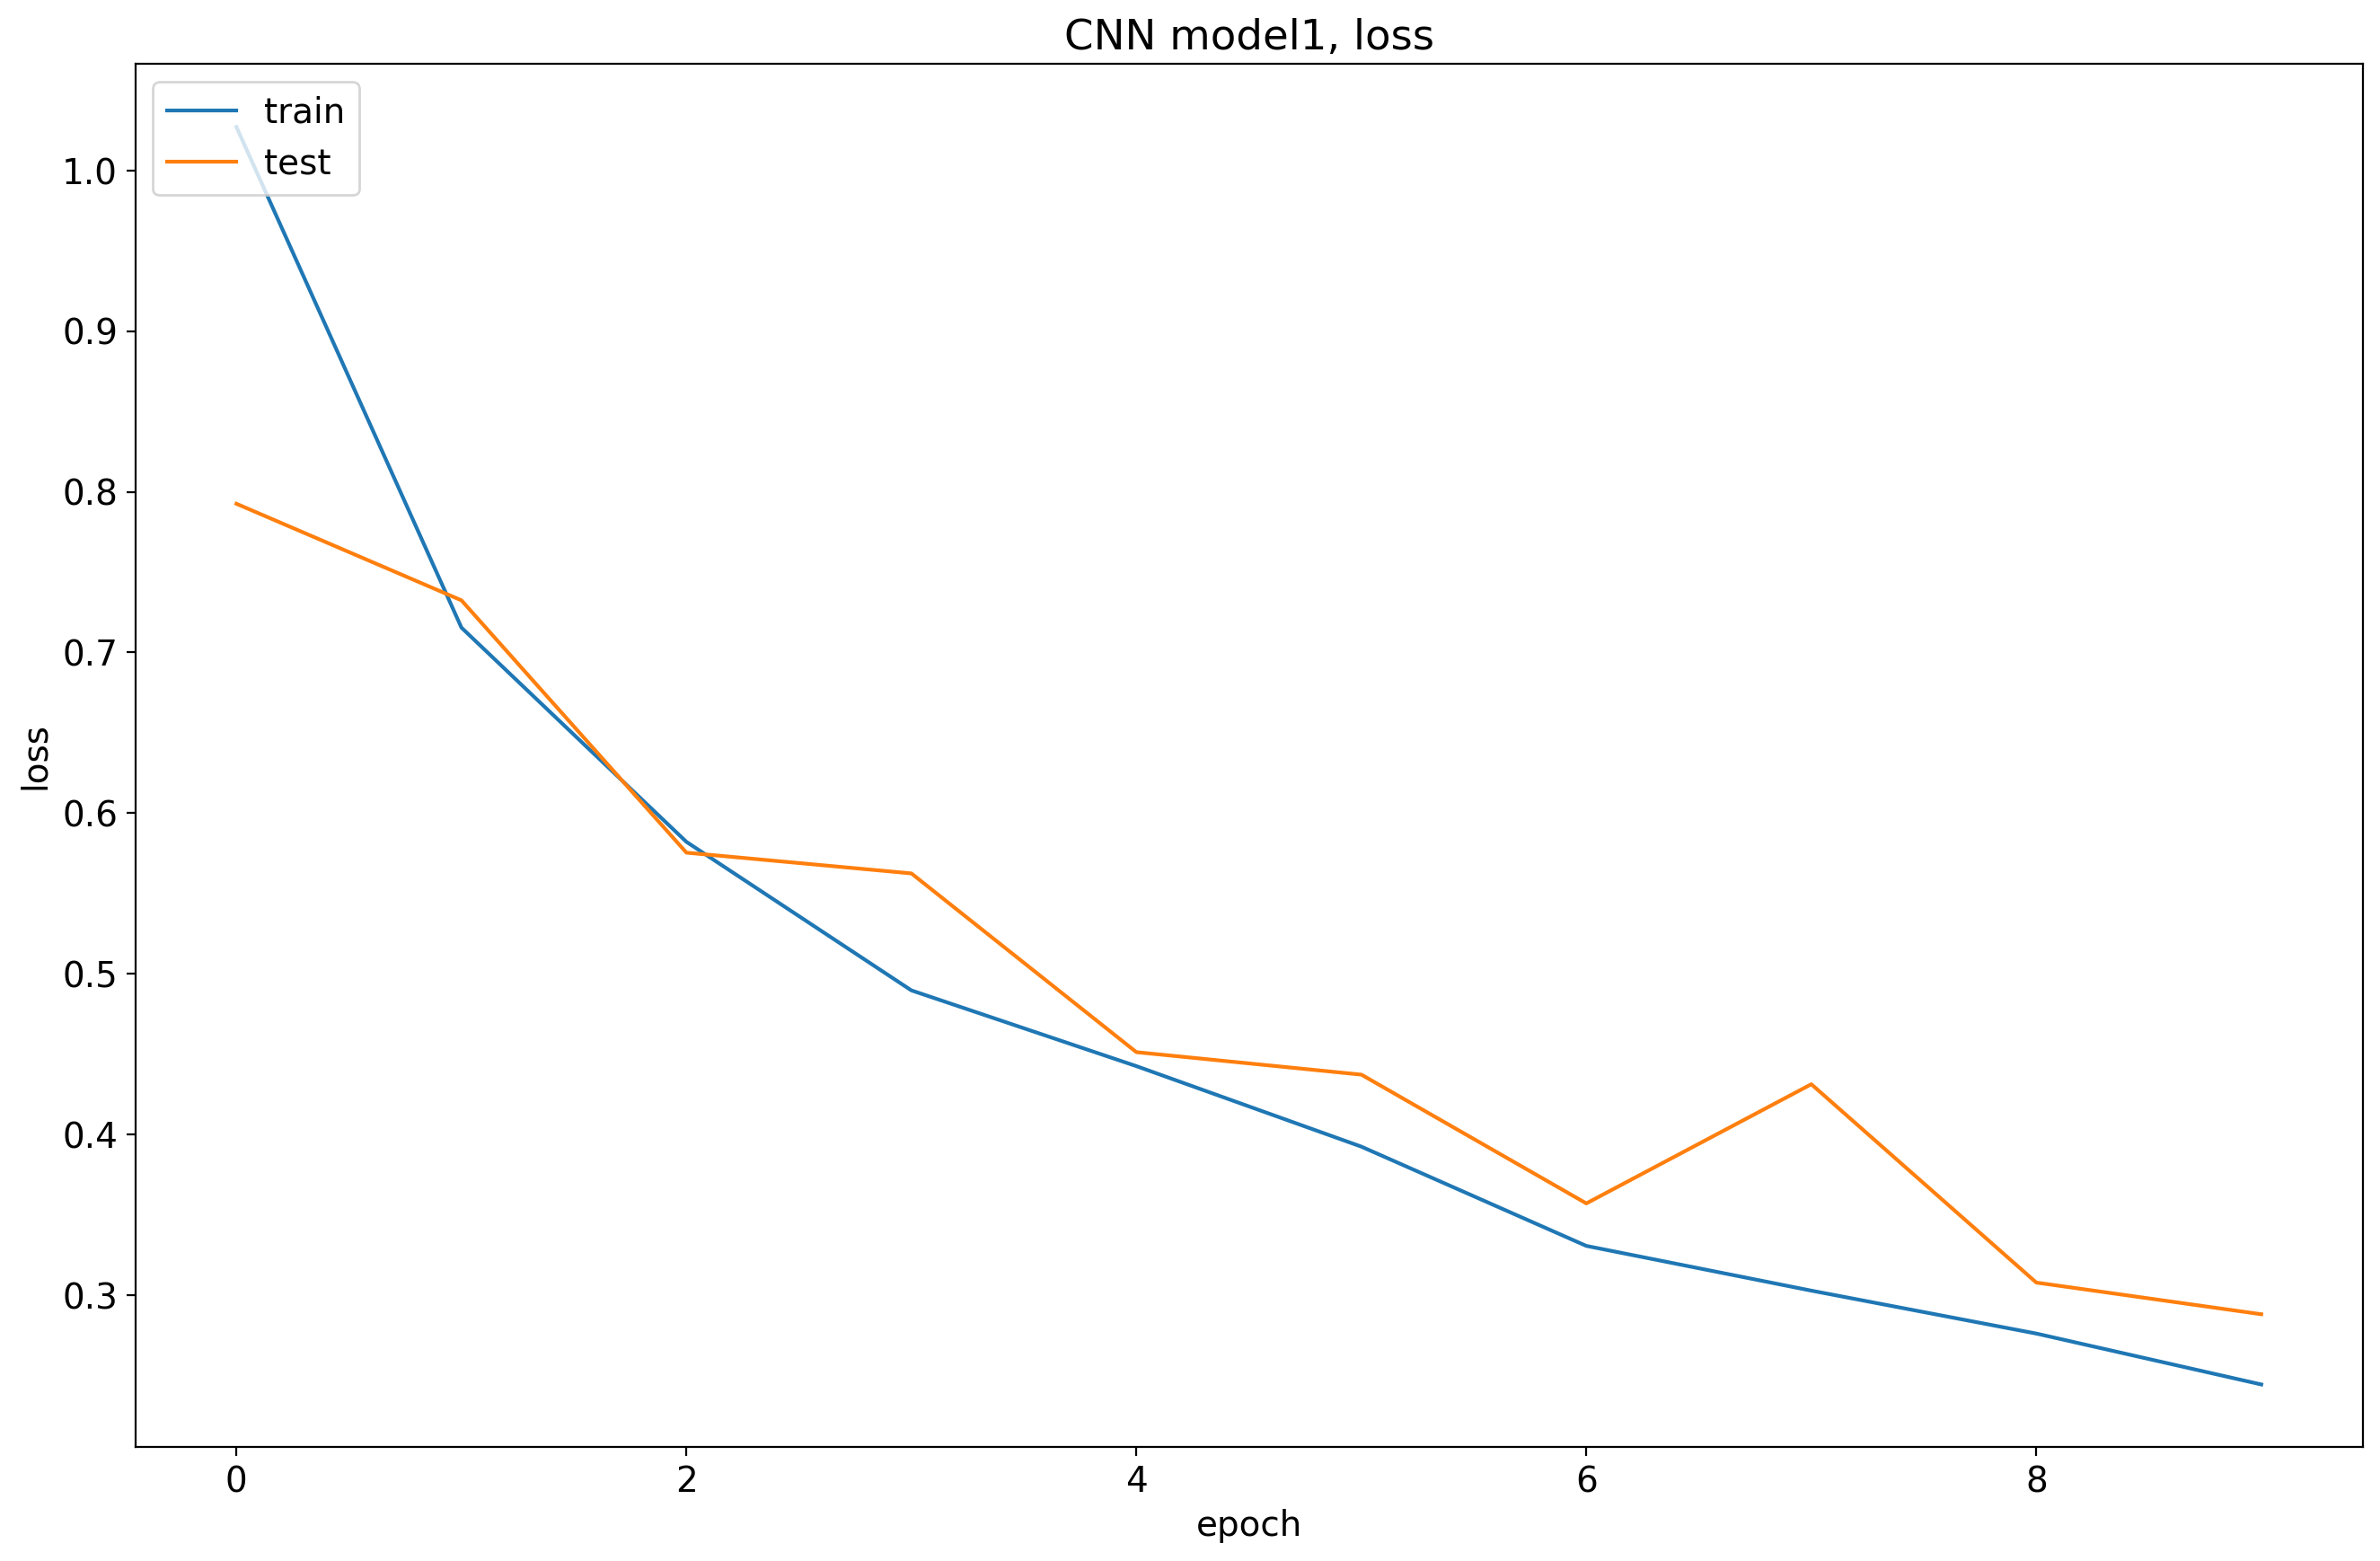

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist6.history['loss'])
plt.plot(hist6.history['val_loss'])
plt.title('CNN model (3 conv2D), loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model6.evaluate(train_ds, verbose=1)
valid_score = model6.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 106ms/step - loss: 0.2880 - accuracy: 0.8986
Train Loss: 0.1873
Train Accuracy: 92.61%
--------------------
Validation Loss: 0.2880
Validation Accuracy: 89.86%


### №3

4 згорткові шари

In [ ]:
model7 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, (4, 4), activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model7.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist7 = model7.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/10
 33/179 [====>.........................] - ETA: 7:01 - loss: nan - accuracy: 0.2197

Збереження моделі:

In [ ]:
model7.save('/content/drive/MyDrive/brain-tumor-models/model7')

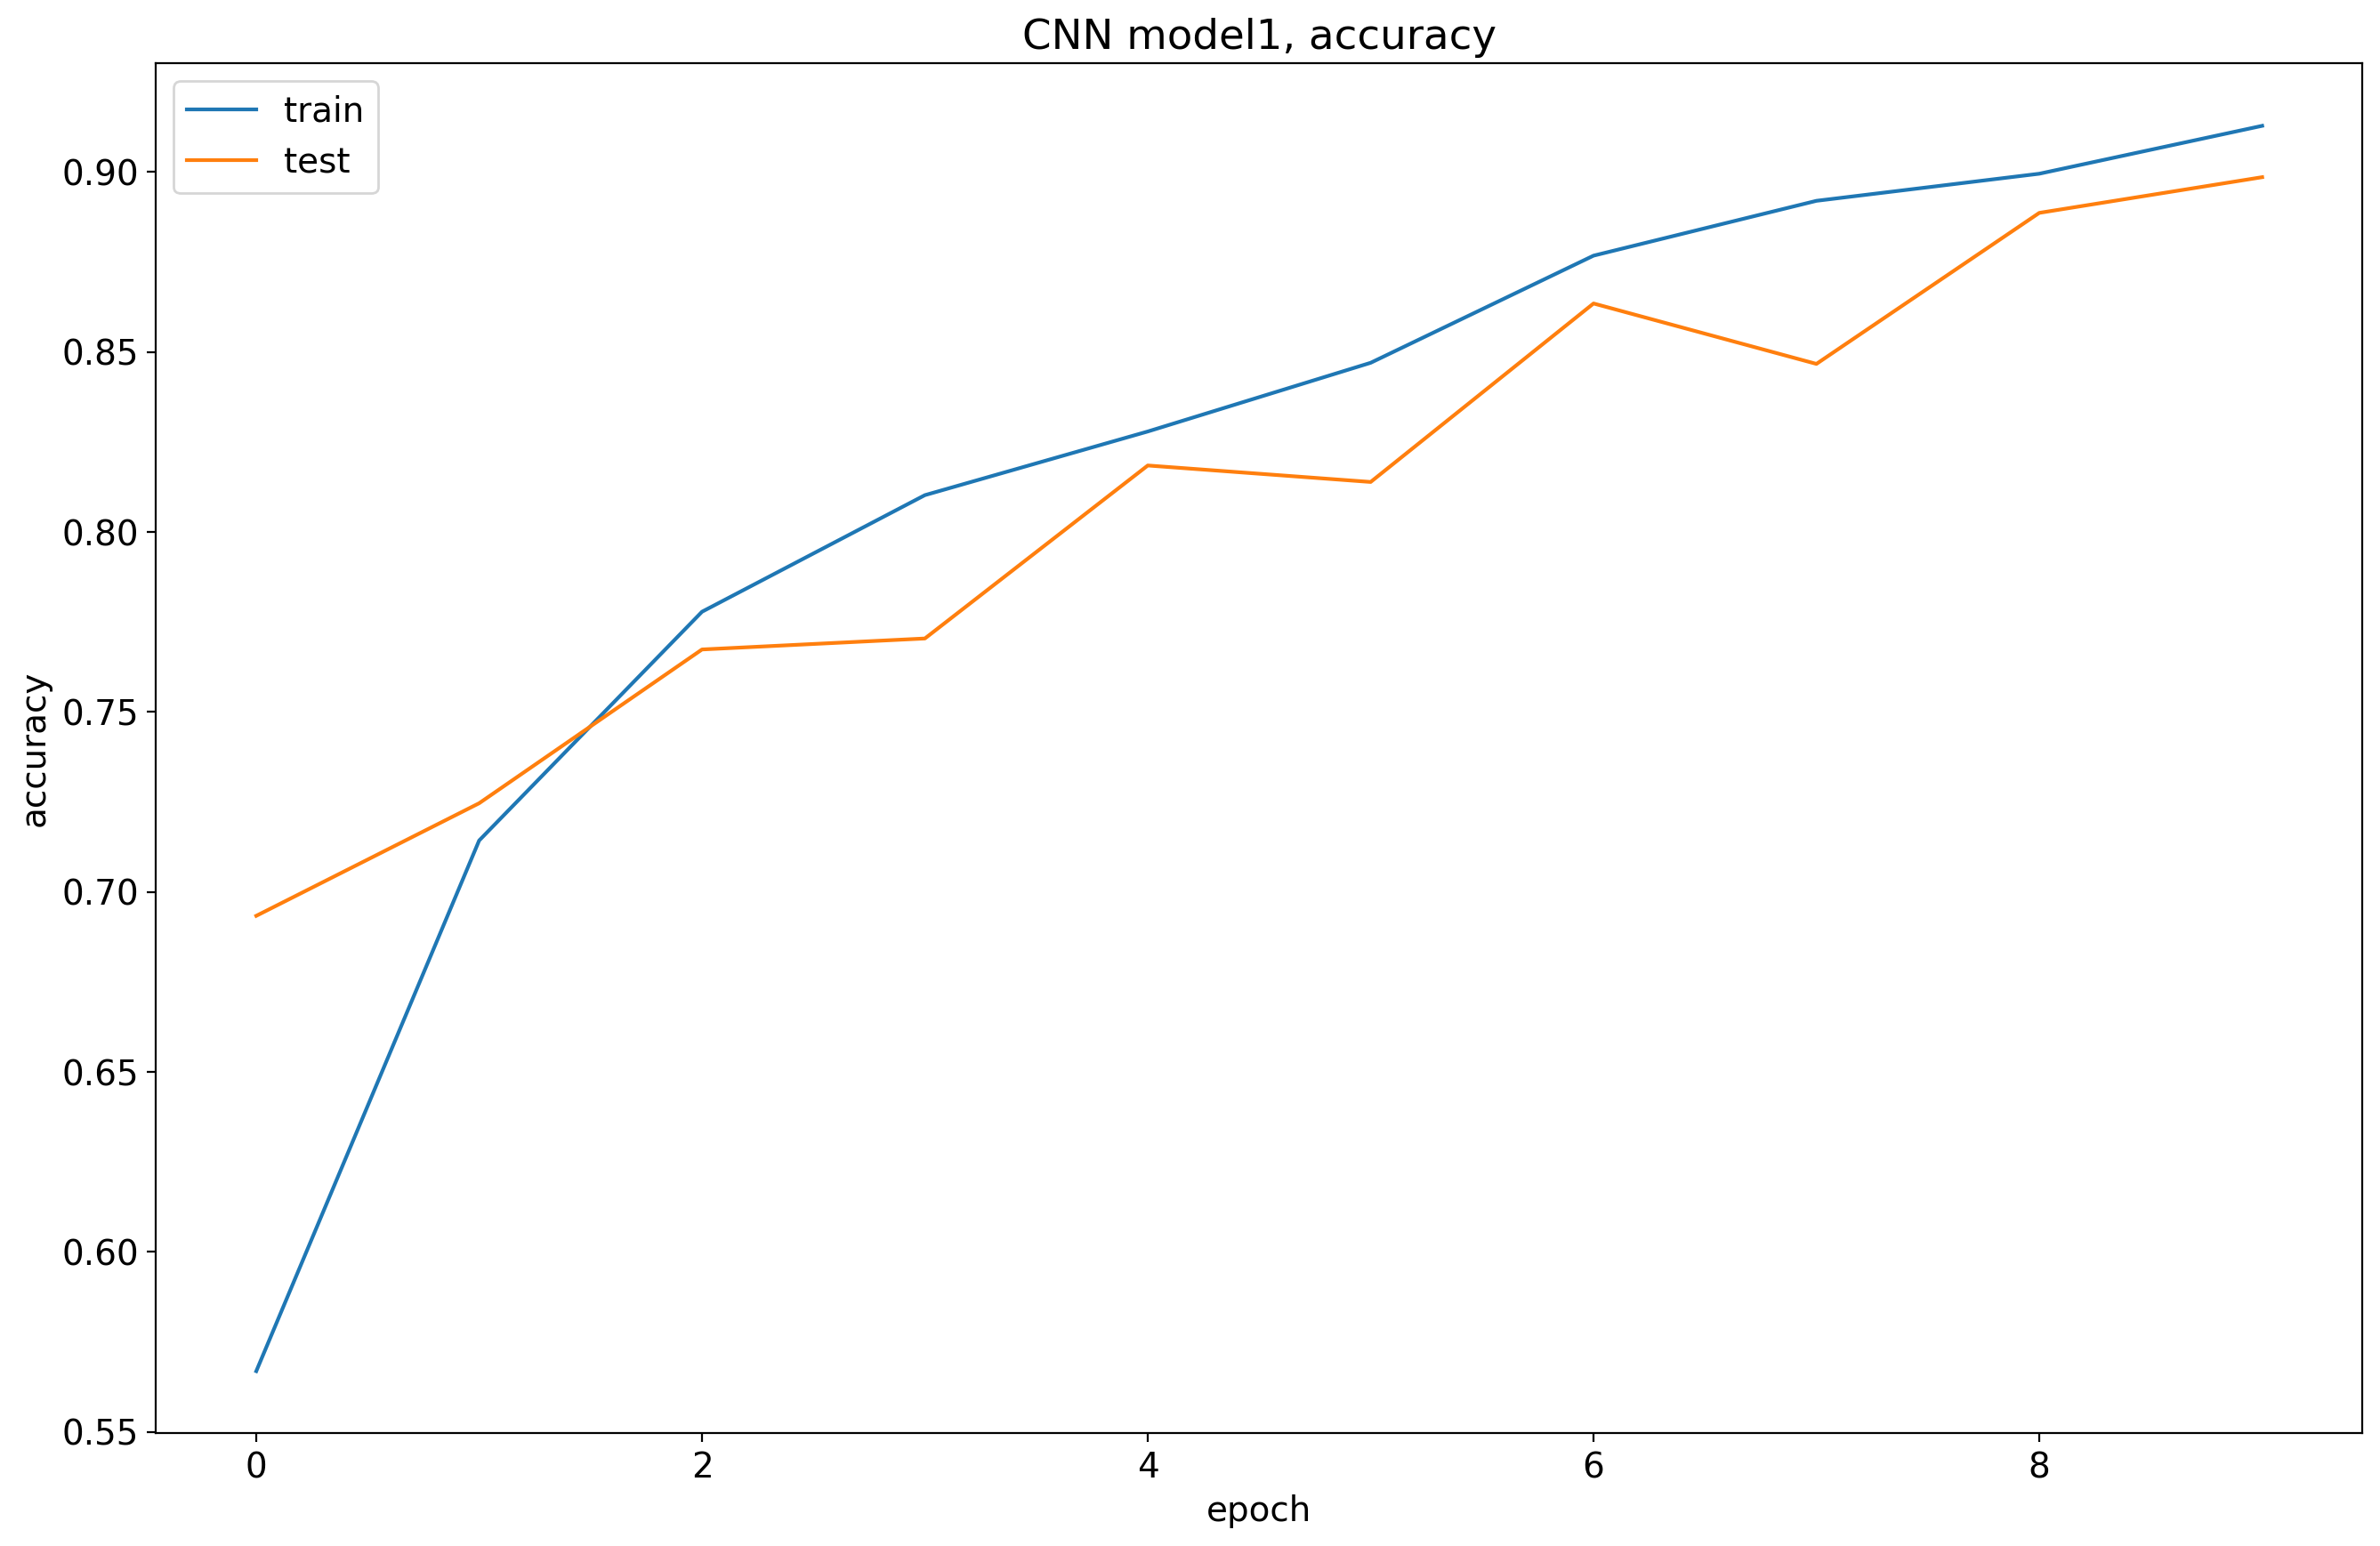

In [ ]:
# графік навчання, точність моделі
plt.plot(hist7.history['accuracy'])
plt.plot(hist7.history['val_accuracy'])
plt.title('CNN model (4 conv2D), accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

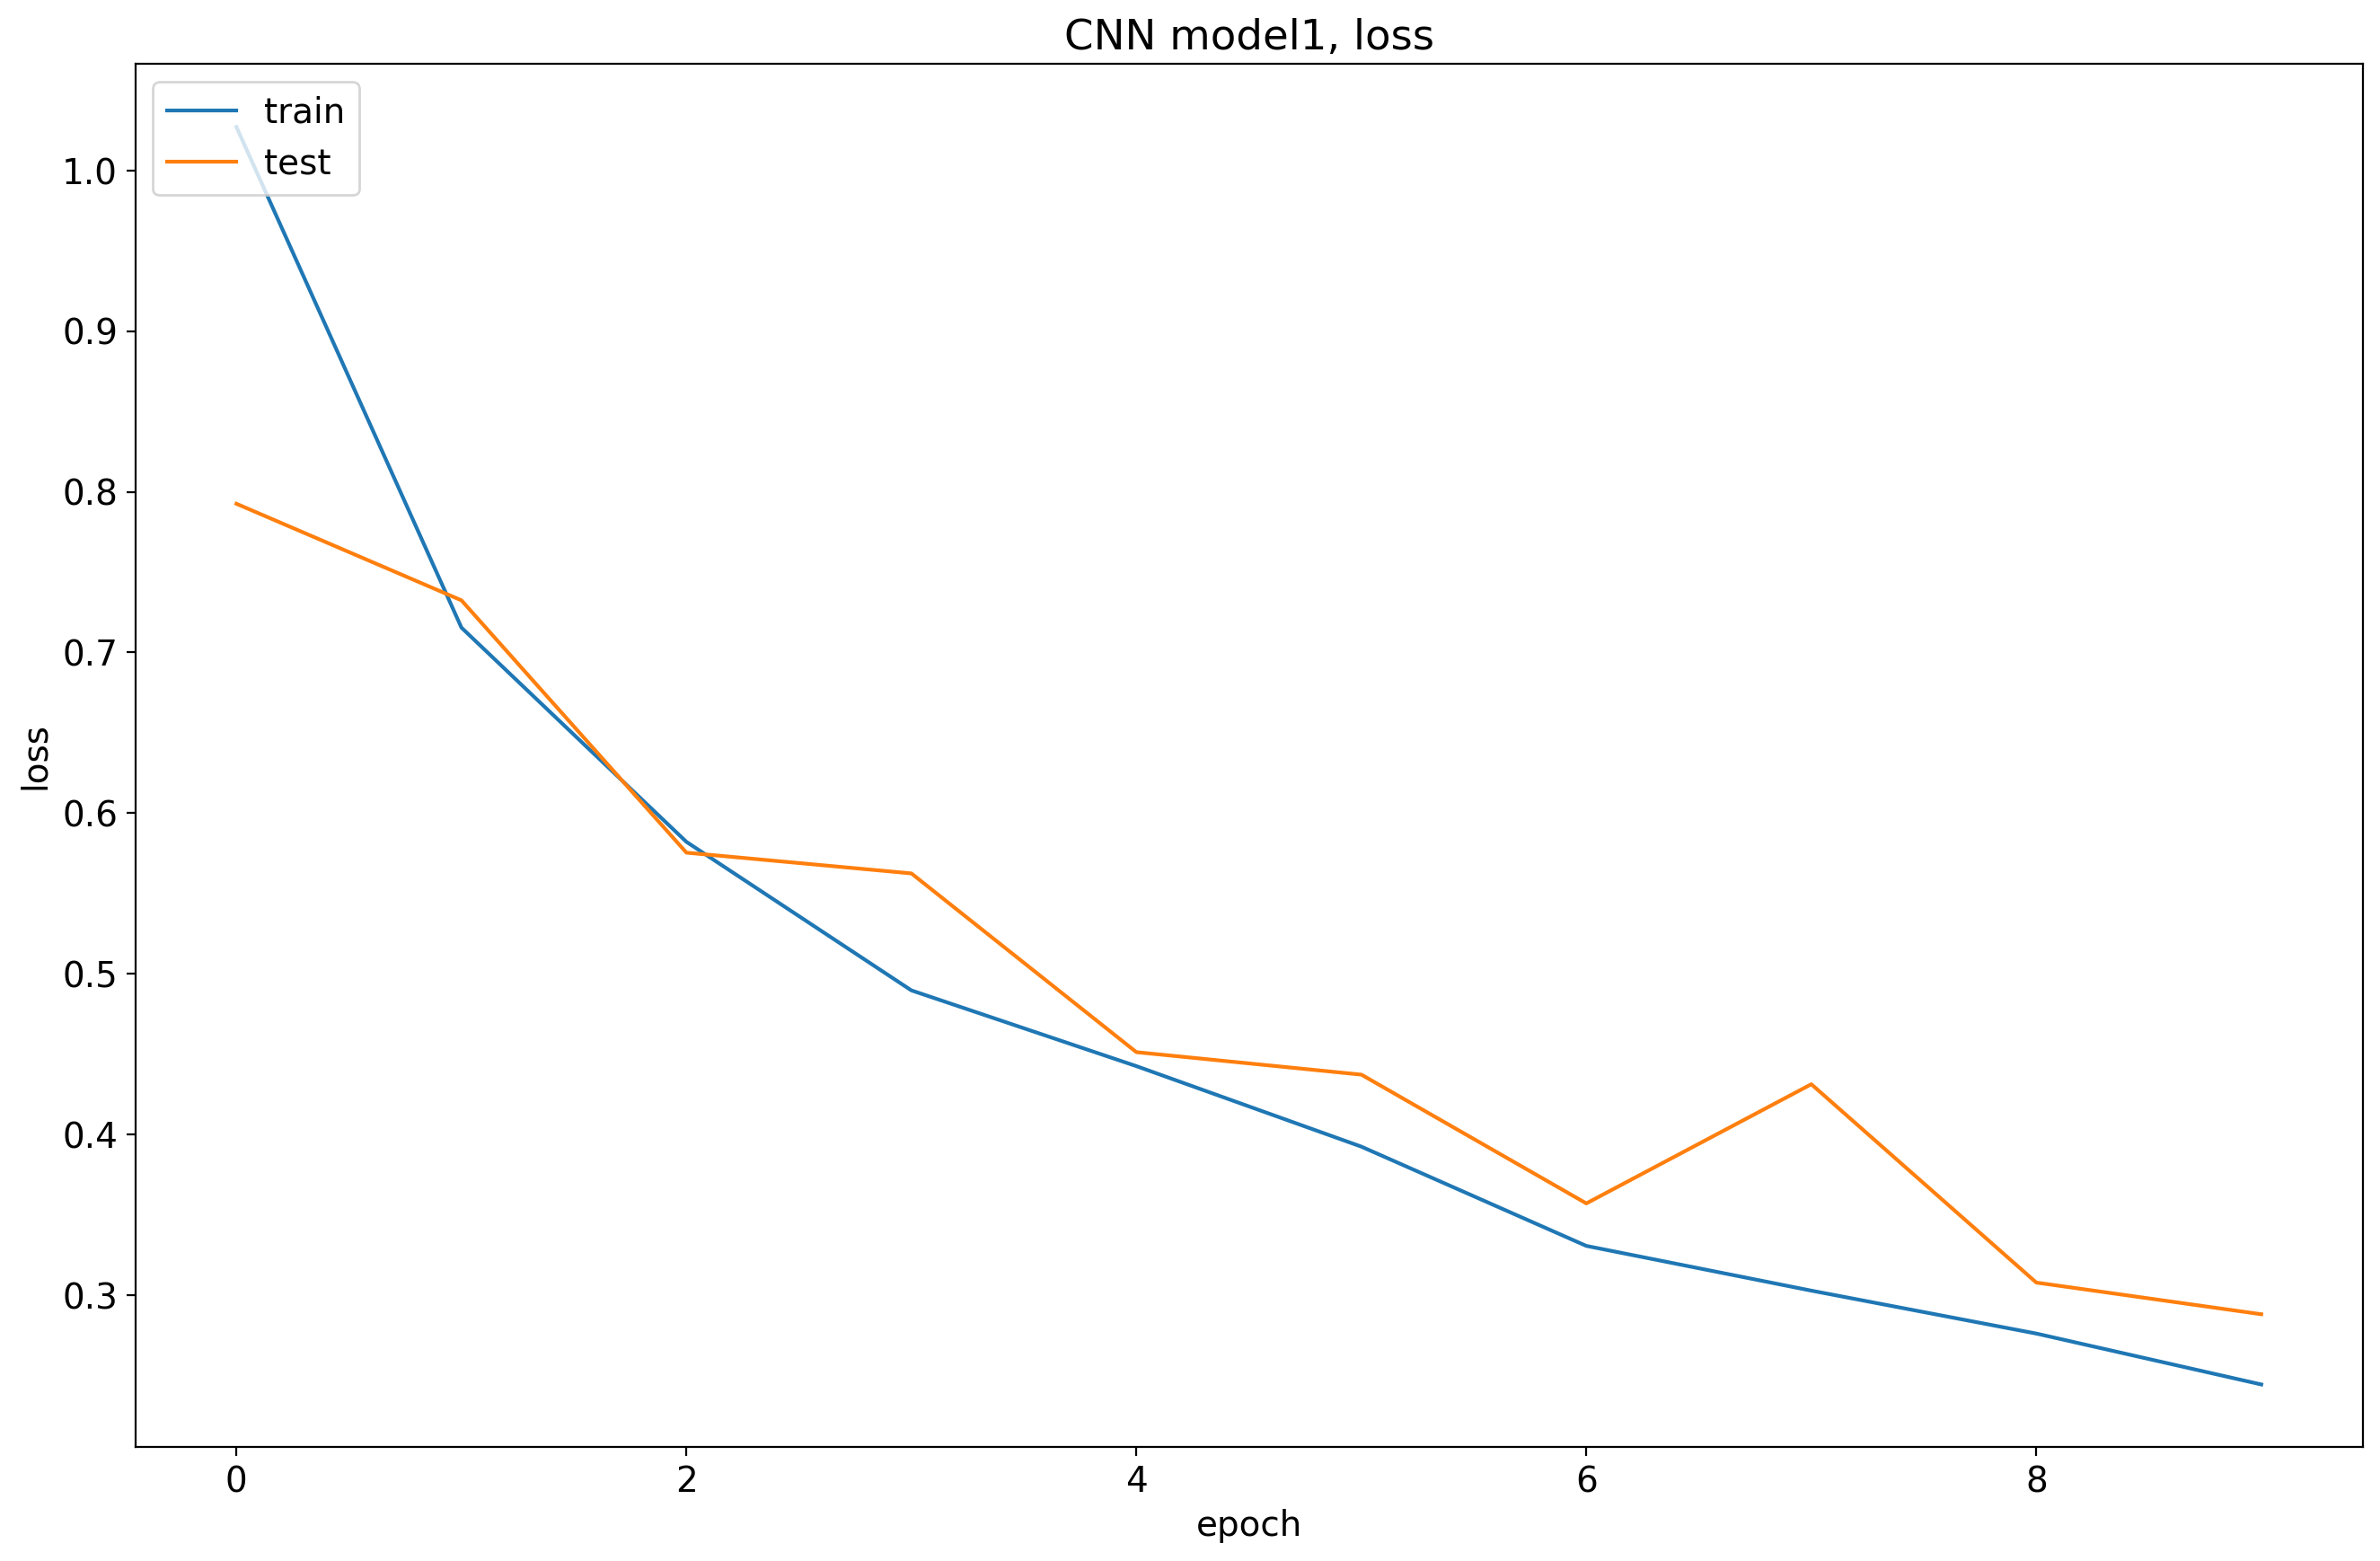

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(hist7.history['loss'])
plt.plot(hist7.history['val_loss'])
plt.title('CNN model (4 conv2D), loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = model6.evaluate(train_ds, verbose=1)
valid_score = model6.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 106ms/step - loss: 0.2880 - accuracy: 0.8986
Train Loss: 0.1873
Train Accuracy: 92.61%
--------------------
Validation Loss: 0.2880
Validation Accuracy: 89.86%


## Фільтри, навчання моделі на зображеннях з фільтром

In [ ]:
import os
import cv2
import numpy as np

def apply_blur_to_images(directory_path, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Зчитуємо всі файли у директорії
    for filename in os.listdir(directory_path):
        # Повний шлях до поточного файлу
        full_path = os.path.join(directory_path, filename)

        # Ігноруємо файли, якщо це не зображення
        if not os.path.isfile(full_path) or not any(full_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            continue

        # Зчитуємо зображення
        image = cv2.imread(full_path)

        # Перевірка чи зображення зчиталося коректно
        if image is None:
            print(f"Не вдалося прочитати зображення: {full_path}")
            continue

        # Застосовуємо фільтр blur (матриця 3x3)
        blurred_image = cv2.blur(image, (3, 3))

        # Зберігаємо змінене зображення у вказану папку з тією ж назвою, що і вихідне
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, blurred_image)

def apply_histogram_equalization_to_images(directory_path, output_directory):
    # Переконайтесь, що вихідна папка існує
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Зчитуємо всі файли у директорії
    for filename in os.listdir(directory_path):
        # Повний шлях до поточного файлу
        full_path = os.path.join(directory_path, filename)

        # Ігноруємо файли, якщо це не зображення
        if not os.path.isfile(full_path) or not any(full_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            continue

        # Зчитуємо зображення
        image = cv2.imread(full_path)

        # Перевірка чи зображення зчиталося коректно
        if image is None:
            print(f"Не вдалося прочитати зображення: {full_path}")
            continue

        # Застосовуємо еквалізацію гістограми
        equalized_image = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

        # Зберігаємо змінене зображення у вказану папку з тією ж назвою, що і вихідне
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, equalized_image)

def apply_sharpening_filter_to_images(directory_path, output_directory):
    # Переконайтесь, що вихідна папка існує
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Зчитуємо всі файли у директорії
    for filename in os.listdir(directory_path):
        # Повний шлях до поточного файлу
        full_path = os.path.join(directory_path, filename)

        # Ігноруємо файли, якщо це не зображення
        if not os.path.isfile(full_path) or not any(full_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            continue

        # Зчитуємо зображення
        image = cv2.imread(full_path)

        # Перевірка чи зображення зчиталося коректно
        if image is None:
            print(f"Не вдалося прочитати зображення: {full_path}")
            continue

        # Застосовуємо фільтр підвищення різкості
        sharpened_image = apply_sharpening_filter(image)

        # Зберігаємо змінене зображення у вказану папку з тією ж назвою, що і вихідне
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, sharpened_image)

def apply_sharpening_filter(image):
    # Створимо ядро для фільтра підвищення різкості
    kernel = np.array([[-1, -1, -1],
                        [-1, 9, -1],
                        [-1, -1, -1]])

    # Застосуємо фільтр підвищення різкості
    sharpened_image = cv2.filter2D(image, -1, kernel)

    return sharpened_image

def apply_gaussian_filter_to_images(directory_path, output_directory):
    # Переконайтесь, що вихідна папка існує
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Зчитуємо всі файли у директорії
    for filename in os.listdir(directory_path):
        # Повний шлях до поточного файлу
        full_path = os.path.join(directory_path, filename)

        # Ігноруємо файли, якщо це не зображення
        if not os.path.isfile(full_path) or not any(full_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            continue

        # Зчитуємо зображення
        image = cv2.imread(full_path)

        # Перевірка чи зображення зчиталося коректно
        if image is None:
            print(f"Не вдалося прочитати зображення: {full_path}")
            continue

        # Застосовуємо фільтр Гауса
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

        # Зберігаємо змінене зображення у вказану папку з тією ж назвою, що і вихідне
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, blurred_image)


In [ ]:
import pathlib

pathes_in = []
#training
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Training/meningioma'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Training/glioma'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Training/notumor'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Training/pituitary'))
#testing
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Testing/meningioma'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Testing/glioma'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Testing/notumor'))
pathes_in.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset/Testing/pituitary'))

pathes_out = []
#training
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Training/meningioma'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Training/glioma'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Training/notumor'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Training/pituitary'))
#testing
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Testing/meningioma'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Testing/glioma'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Testing/notumor'))
pathes_out.append(pathlib.Path('/content/drive/MyDrive/brain-tumor-dataset-filt/Testing/pituitary'))

In [ ]:
print(len(pathes_in))

8


In [ ]:
# застосування фільтру до зображень + час вимірювання; BLUR
import time

start_time = time.time()
for i in range(len(pathes_in)):
  input_dir = pathes_in[i]
  output_dir = pathes_out[i]
  apply_blur_to_images(input_dir, output_dir)
end_time = time.time()
res_time = end_time - start_time
print(f"Час фільтрування: {res_time} секунд.")

Час фільтрування: 175.52073001861572 секунд.


In [ ]:
# застосування фільтру до зображень + час вимірювання; histogram equalization
import time

start_time = time.time()
for i in range(len(pathes_in)):
  input_dir = pathes_in[i]
  output_dir = pathes_out[i]
  apply_histogram_equalization_to_images(input_dir, output_dir)
end_time = time.time()
res_time = end_time - start_time
print(f"Час фільтрування: {res_time} секунд.")

Час фільтрування: 175.51000905036926 секунд.


In [ ]:
# застосування фільтру до зображень + час вимірювання; sharpening filter
import time

start_time = time.time()
for i in range(len(pathes_in)):
  input_dir = pathes_in[i]
  output_dir = pathes_out[i]
  apply_sharpening_filter_to_images(input_dir, output_dir)
end_time = time.time()
res_time = end_time - start_time
print(f"Час фільтрування: {res_time} секунд.")

Час фільтрування: 205.35873556137085 секунд.


In [ ]:
# застосування фільтру до зображень + час вимірювання; Gaussian blur
import time

start_time = time.time()
for i in range(len(pathes_in)):
  input_dir = pathes_in[i]
  output_dir = pathes_out[i]
  apply_gaussian_filter_to_images(input_dir, output_dir)
end_time = time.time()
res_time = end_time - start_time
print(f"Час фільтрування: {res_time} секунд.")

Час фільтрування: 260.10757994651794 секунд.


In [ ]:
import pathlib  # для директорії з даними

dataset_path_train = '/content/drive/MyDrive/brain-tumor-dataset-filt/Training'
data_dir_train = pathlib.Path(dataset_path_train)  # об'єкт із шляхом до датасету, тренувальний набір, на диску

dataset_path_test = '/content/drive/MyDrive/brain-tumor-dataset-filt/Testing'
data_dir_test = pathlib.Path(dataset_path_test)  # об'єкт із шляхом до датасету, тестувальний набір,  на диску

In [ ]:
image_count_tr = len(list(data_dir_train.glob('*/*.jpg')))
print('Training:', image_count_tr)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Testing:', image_count_test)
print('Total images count:', image_count_tr + image_count_test)

Training: 5712
Testing: 1311
Total images count: 7023


Створимо набір тренувальних даних через директорію:

In [ ]:
import tensorflow as tf

ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,  # шлях
  batch_size=32)  # розмір "партії" даних

Found 5712 files belonging to 4 classes.


Аналогічно створимо набір валідаційних даних через директорію:

In [ ]:
ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  batch_size=32)

Found 1311 files belonging to 4 classes.


Назви класів:

In [ ]:
class_names = ds_train.class_names
classes_count = len(class_names)
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

Застосуємо перетворення зображень до необхідного формату + випадкових перетворень (зміна контрасту, яскравости, випадкове горизонтальне-вертикальне перевертання).

In [ ]:
train_ds = ds_train.map(train_transform)
val_ds = ds_val.map(val_transform)

Ініціалізація моделі:

In [ ]:
model2 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.5, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

hist2 = model2.fit(train_ds,
                 epochs=10,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Результат навчання:

In [ ]:
# результат без фільтрів
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 8s 146ms/step - loss: 0.2047 - accuracy: 0.9214
Train Loss: 0.1410
Train Accuracy: 94.70%
--------------------
Validation Loss: 0.2047
Validation Accuracy: 92.14%


In [ ]:
# звичайний BLUR
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 96ms/step - loss: 0.1530 - accuracy: 0.9458
Train Loss: 0.0957
Train Accuracy: 96.73%
--------------------
Validation Loss: 0.1530
Validation Accuracy: 94.58%


In [ ]:
# histogram equalization
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 103ms/step - loss: 0.2674 - accuracy: 0.8818
Train Loss: 0.1611
Train Accuracy: 93.77%
--------------------
Validation Loss: 0.2674
Validation Accuracy: 88.18%


In [ ]:
# sharpening filter
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 111ms/step - loss: 0.1985 - accuracy: 0.9420
Train Loss: 0.0875
Train Accuracy: 97.36%
--------------------
Validation Loss: 0.1985
Validation Accuracy: 94.20%


In [ ]:
# Gaussian blur
train_score = model2.evaluate(train_ds, verbose=1)
valid_score = model2.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 1s 14ms/step - loss: 0.9027 - accuracy: 0.8406
Train Loss: 0.1398
Train Accuracy: 95.41%
--------------------
Validation Loss: 0.9027
Validation Accuracy: 84.06%


## Розпаралелення застосування фільтра

**Дана частина коду виконувалась локально.*

In [ ]:
pip install opencv-python

     ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
     --------------------------------------- 0.0/38.6 MB 991.0 kB/s eta 0:00:39
     --------------------------------------- 0.0/38.6 MB 991.0 kB/s eta 0:00:39
     ---------------------------------------- 0.2/38.6 MB 1.3 MB/s eta 0:00:30
     ---------------------------------------- 0.2/38.6 MB 1.2 MB/s eta 0:00:33
     ---------------------------------------- 0.3/38.6 MB 1.2 MB/s eta 0:00:32
     ---------------------------------------- 0.3/38.6 MB 1.1 MB/s eta 0:00:35
     ---------------------------------------- 0.4/38.6 MB 1.2 MB/s eta 0:00:32
     ---------------------------------------- 0.4/38.6 MB 1.2 MB/s eta 0:00:32
     ---------------------------------------- 0.4/38.6 MB 1.2 MB/s eta 0:00:32
     ---------------------------------------- 0.4/38.6 MB 1.2 MB/s eta 0:00:32
      --------------------------------------- 0.7/38.6 MB 1.4 MB/s eta 0:00:27
      --------------------------------------- 0.7/38.6 MB


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Функція застосування фільтра

In [ ]:
import os
import cv2
import numpy as np

def apply_blur_to_images(directory_path, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Зчитуємо всі файли у директорії
    for filename in os.listdir(directory_path):
        # Повний шлях до поточного файлу
        full_path = os.path.join(directory_path, filename)

        # Ігноруємо файли, якщо це не зображення
        if not os.path.isfile(full_path) or not any(full_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png']):
            continue

        # Зчитуємо зображення
        image = cv2.imread(full_path)

        # Перевірка чи зображення зчиталося коректно
        if image is None:
            print(f"Не вдалося прочитати зображення: {full_path}")
            continue

        # Застосовуємо фільтр blur (матриця 3x3)
        blurred_image = cv2.blur(image, (3, 3))

        # Зберігаємо змінене зображення у вказану папку з тією ж назвою, що і вихідне
        output_path = os.path.join(output_directory, filename)
        cv2.imwrite(output_path, blurred_image)

In [ ]:
import pathlib

pathes_in = []
#training
pathes_in.append(pathlib.Path('brain-tumor-ds/Training/meningioma'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Training/glioma'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Training/notumor'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Training/pituitary'))
#testing
pathes_in.append(pathlib.Path('brain-tumor-ds/Testing/meningioma'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Testing/glioma'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Testing/notumor'))
pathes_in.append(pathlib.Path('brain-tumor-ds/Testing/pituitary'))

pathes_out = []
#training
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Training/meningioma'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Training/glioma'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Training/notumor'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Training/pituitary'))
#testing
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Testing/meningioma'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Testing/glioma'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Testing/notumor'))
pathes_out.append(pathlib.Path('brain-tumor-ds-filt/Testing/pituitary'))

print(len(pathes_in))

8


Застосування фільтра до зображень без розпаралелення

In [ ]:
import time

start_time = time.time()
for i in range(len(pathes_in)):
  input_dir = pathes_in[i]
  output_dir = pathes_out[i]
  apply_blur_to_images(input_dir, output_dir)
end_time = time.time()
res_time = end_time - start_time
print(f"Час фільтрування: {res_time} секунд.")

Час фільтрування: 127.26928758621216 секунд.


К-ть часу при паралельному застосуванні фільтра

In [ ]:
parallel_times = []

In [ ]:
parallel_times.clear()

In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor

# Функція для обробки зображень
def process_image(input_dir, output_dir):
    apply_blur_to_images(input_dir, output_dir)

# Задання кількості потоків
threads = [1, 2, 4, 6, 8, 12, 16]  # Змініть це на бажане число потоків

for num_threads in threads:
    with ThreadPoolExecutor(max_workers=num_threads) as executor: # створення пулу потоків
        # Подача завдань на обробку зображень до пулу потоків
        start_time = time.time()
        futures = [executor.submit(process_image, pathes_in[i], pathes_out[i]) for i in range(len(pathes_in))]
        for future in futures:
            future.result()
        end_time = time.time() # очікування завершення усіх завдань ^
        res_time = end_time - start_time
        print(f"Час застосування фільтру з {num_threads} потоками: {res_time} секунд.")
        parallel_times.append(res_time)


Час застосування фільтру з 1 потоками: 133.70990180969238 секунд.
Час застосування фільтру з 2 потоками: 82.22461175918579 секунд.
Час застосування фільтру з 4 потоками: 51.3760507106781 секунд.
Час застосування фільтру з 6 потоками: 46.475914001464844 секунд.
Час застосування фільтру з 8 потоками: 44.713645935058594 секунд.
Час застосування фільтру з 12 потоками: 44.96782660484314 секунд.
Час застосування фільтру з 16 потоками: 44.80763649940491 секунд.


Прискорення та ефективність:

In [ ]:
print(len(parallel_times))

7


In [ ]:
S_filt = parallel_times[0] / parallel_times[2]
E_filt = S_filt / 4

print(f"Паралельне прискорення (весь набір даних): {S_filt}")
print(f"Ефективність (весь набір даних): {E_filt}")

Паралельне прискорення (весь набір даних): 2.6025725987128445
Ефективність (весь набір даних): 0.6506431496782111


## Кінцева модель

In [ ]:
model2 = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.3, seed=SEED),
  tf.keras.layers.Dense(classes_count)
  ])

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
modelfin = models.Sequential([
  # Convolutional layer 1
  tf.keras.layers.Conv2D(32, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 2
  tf.keras.layers.Conv2D(64, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

  # Convolutional layer 3
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),

# Convolutional layer 4
  tf.keras.layers.Conv2D(128, 4, activation="relu"),
  tf.keras.layers.Flatten(),

# Full connect layers
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(0.3, seed=SEED),
  tf.keras.layers.Dense(classes_count)

  ])

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

modelfin.compile(optimizer=Adam(learning_rate=0.001),
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Навчання:

In [ ]:
start_time = time.time()

histfin = modelfin.fit(train_ds,
                 epochs=13,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/13
179/179 [==============================] - 63s 249ms/step - loss: 0.9182 - accuracy: 0.6148 - val_loss: 0.7479 - val_accuracy: 0.7254
Epoch 2/13
179/179 [==============================] - 44s 242ms/step - loss: 0.6285 - accuracy: 0.7619 - val_loss: 0.6627 - val_accuracy: 0.7185
Epoch 3/13
179/179 [==============================] - 43s 233ms/step - loss: 0.4853 - accuracy: 0.8141 - val_loss: 0.5366 - val_accuracy: 0.7963
Epoch 4/13
179/179 [==============================] - 43s 236ms/step - loss: 0.4015 - accuracy: 0.8512 - val_loss: 0.4319 - val_accuracy: 0.8330
Epoch 5/13
179/179 [==============================] - 43s 236ms/step - loss: 0.3341 - accuracy: 0.8782 - val_loss: 0.3412 - val_accuracy: 0.8665
Epoch 6/13
179/179 [==============================] - 47s 260ms/step - loss: 0.2927 - accuracy: 0.8916 - val_loss: 0.2878 - val_accuracy: 0.8917
Epoch 7/13
179/179 [==============================] - 44s 238ms/step - loss: 0.2401 - accuracy: 0.9118 - val_loss: 0.2888 - val_ac

Збереження моделі:

In [ ]:
modelfin.save('/content/drive/MyDrive/brain-tumor-models/modelfin')

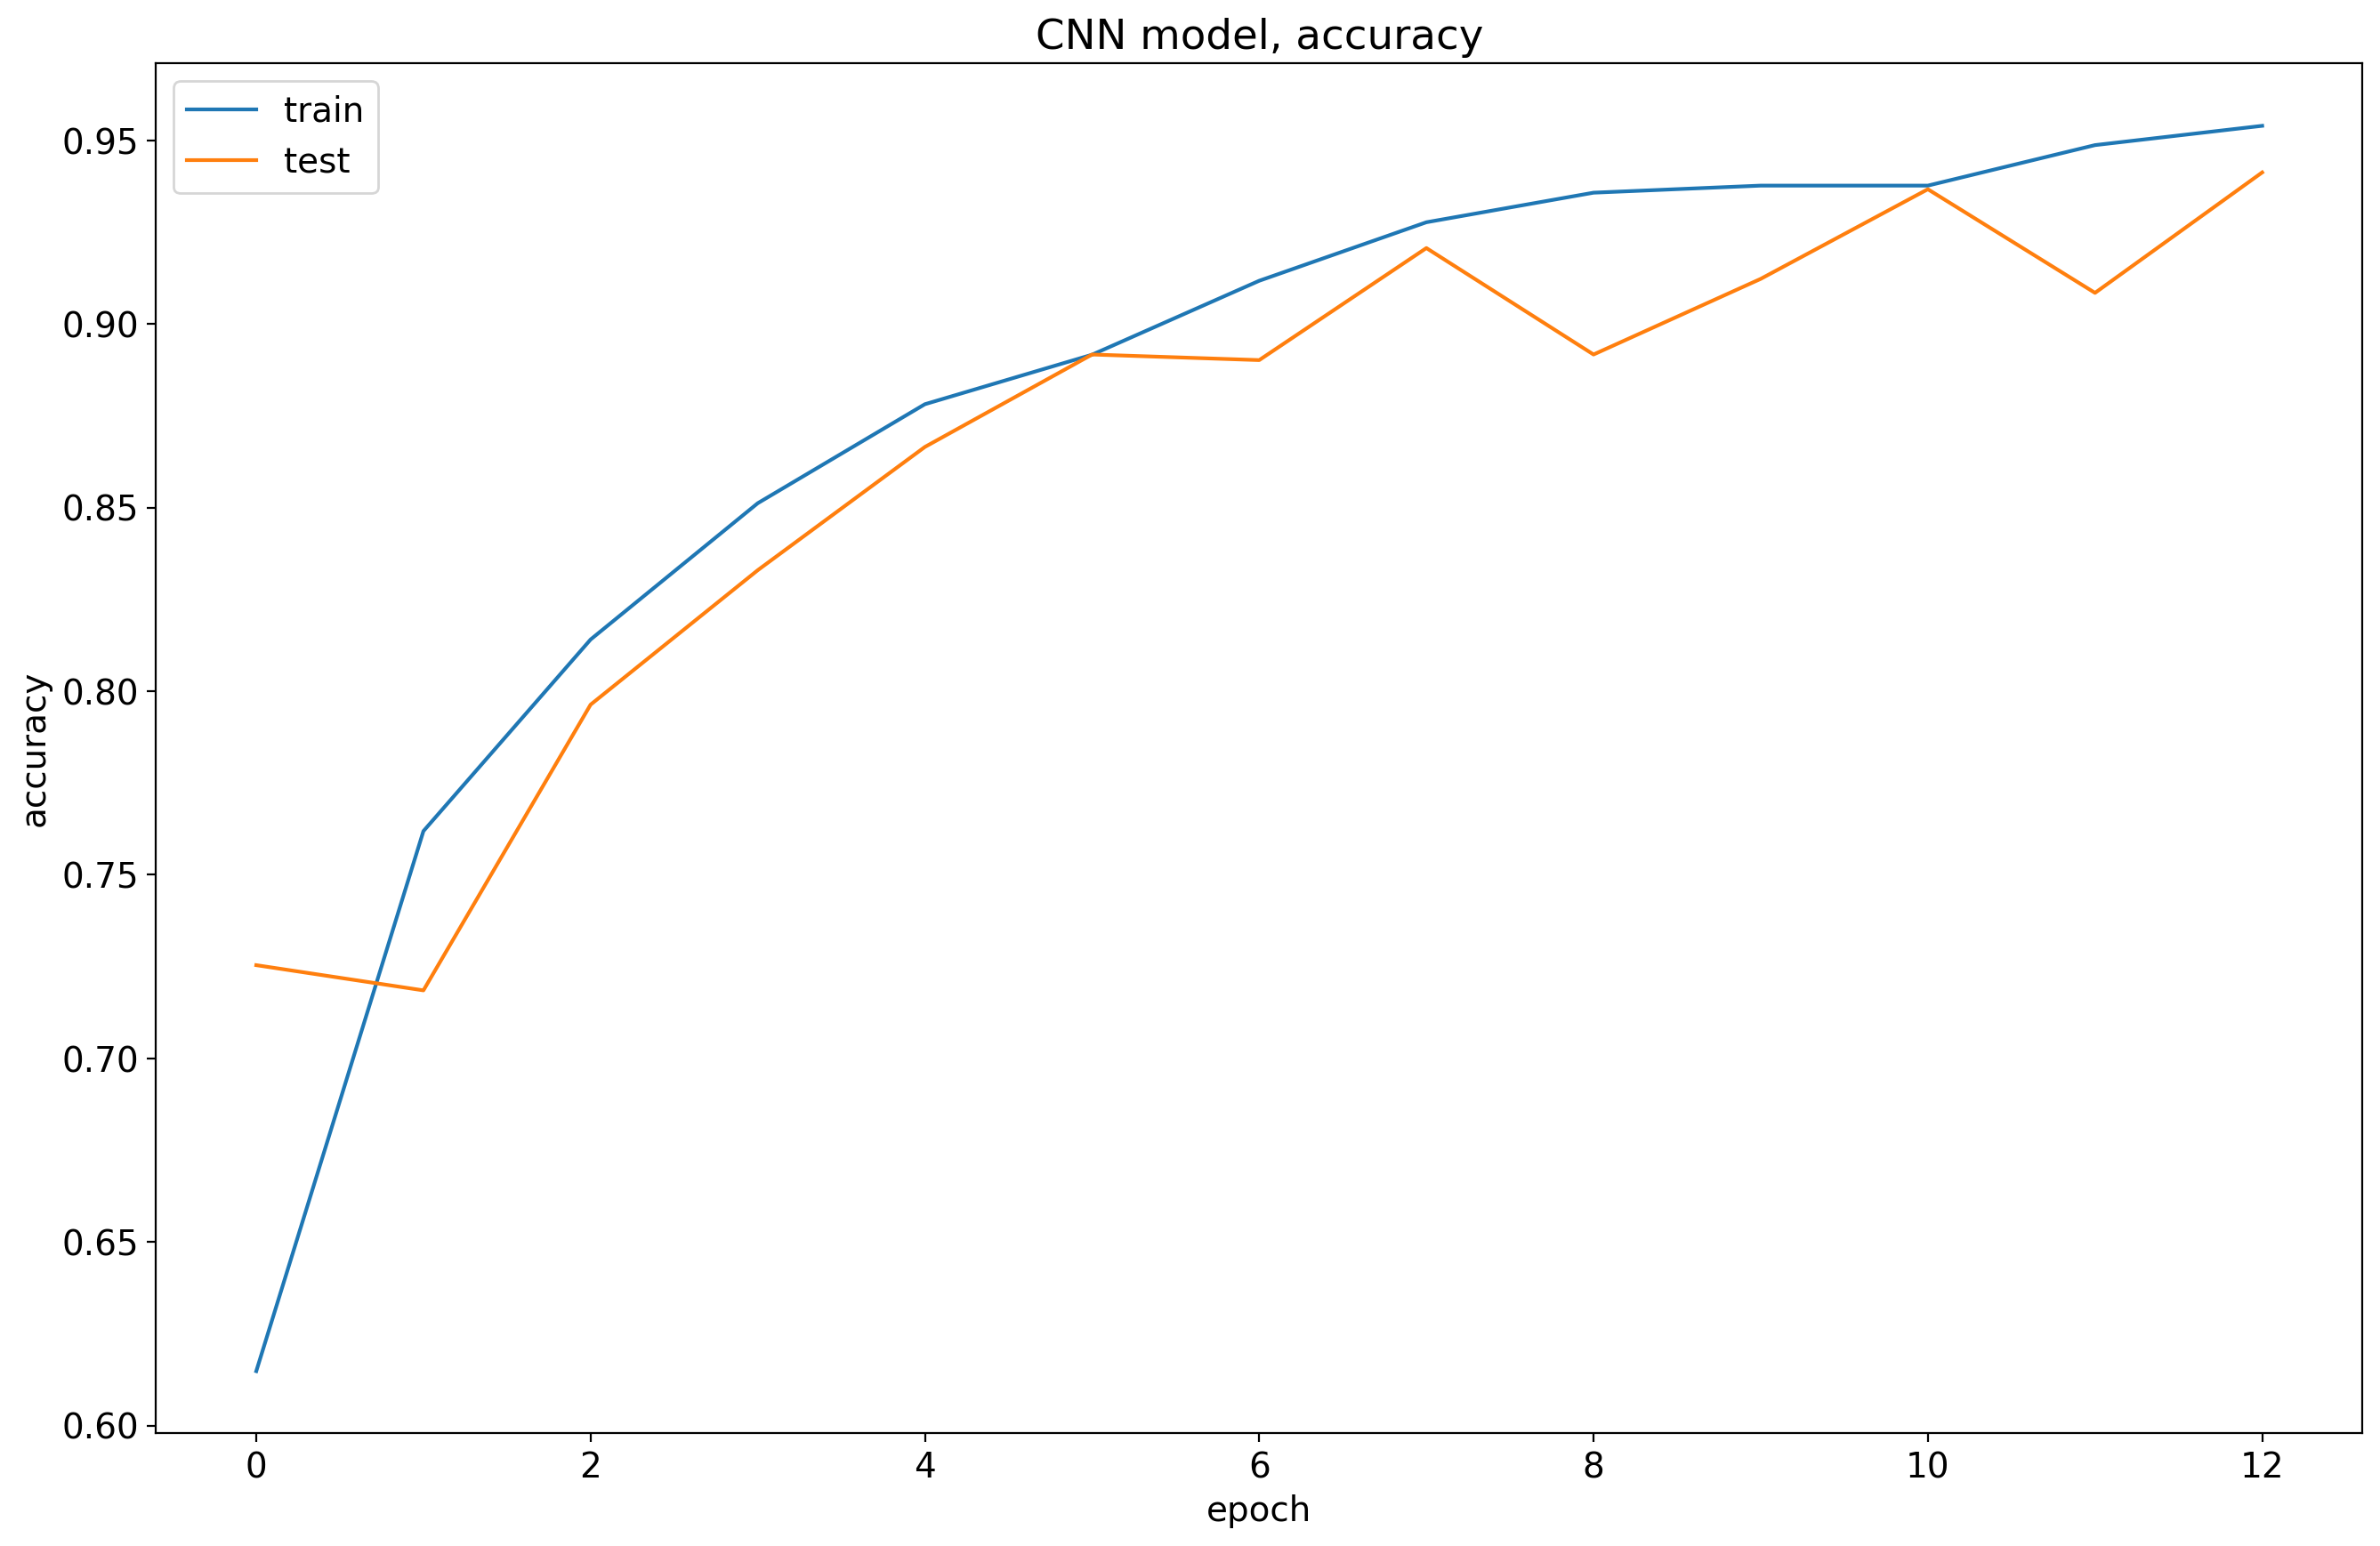

In [ ]:
# графік навчання, точність моделі
plt.plot(histfin.history['accuracy'])
plt.plot(histfin.history['val_accuracy'])
plt.title('CNN model, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

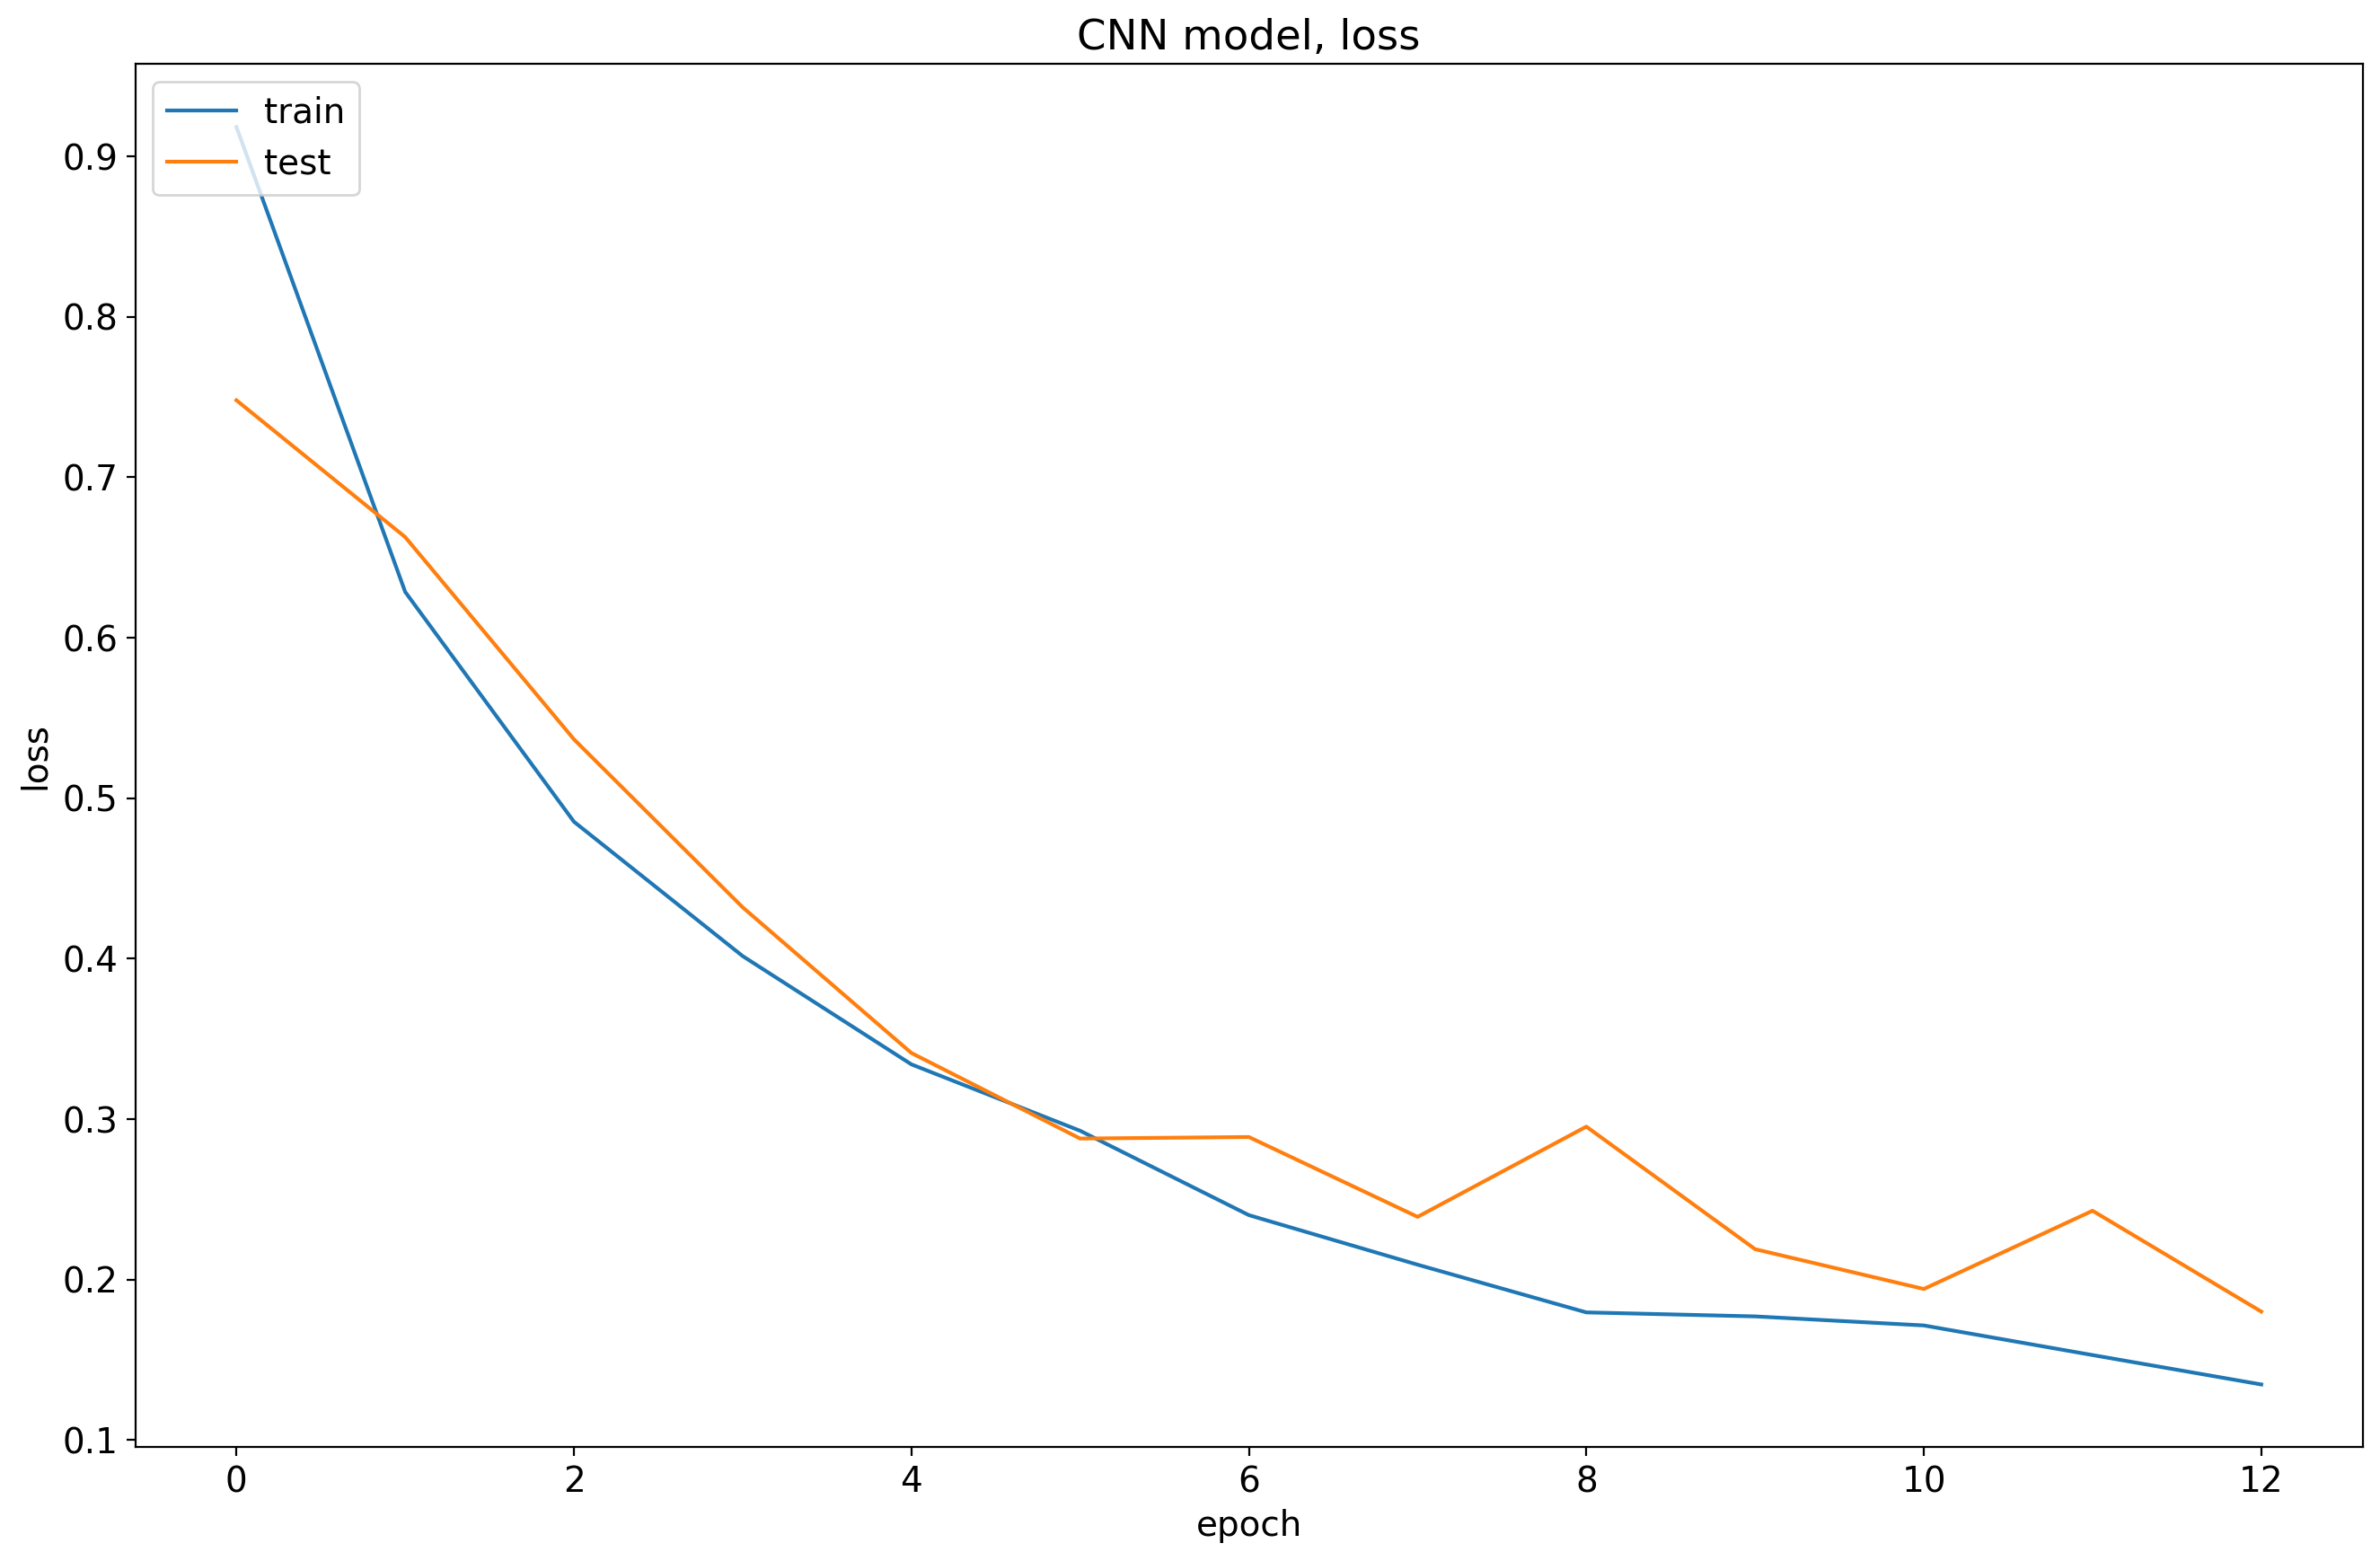

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(histfin.history['loss'])
plt.plot(histfin.history['val_loss'])
plt.title('CNN model, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_score = modelfin.evaluate(train_ds, verbose=1)
valid_score = modelfin.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 94ms/step - loss: 0.1800 - accuracy: 0.9413
Train Loss: 0.1167
Train Accuracy: 95.82%
--------------------
Validation Loss: 0.1800
Validation Accuracy: 94.13%


Довчили модель ще на 2 епохах:

In [ ]:
start_time = time.time()

histfin = modelfin.fit(train_ds,
                 epochs=2,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/2
179/179 [==============================] - 47s 255ms/step - loss: 0.1272 - accuracy: 0.9550 - val_loss: 0.1657 - val_accuracy: 0.9405
Epoch 2/2
179/179 [==============================] - 47s 260ms/step - loss: 0.1132 - accuracy: 0.9631 - val_loss: 0.1912 - val_accuracy: 0.9436
Час тренування: 129.34560990333557 секунд


In [ ]:
train_score = modelfin.evaluate(train_ds, verbose=1)
valid_score = modelfin.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 94ms/step - loss: 0.1912 - accuracy: 0.9436
Train Loss: 0.0777
Train Accuracy: 97.20%
--------------------
Validation Loss: 0.1912
Validation Accuracy: 94.36%


Довчили ще на 3 епохах (18 в сумі):

In [ ]:
start_time = time.time()

histfin = modelfin.fit(train_ds,
                 epochs=3,
                 validation_data=val_ds,
                 shuffle=False)

end_time = time.time()
training_time = end_time - start_time

print(f"Час тренування: {training_time} секунд")

Epoch 1/3
179/179 [==============================] - 58s 314ms/step - loss: 0.1034 - accuracy: 0.9653 - val_loss: 0.2187 - val_accuracy: 0.9283
Epoch 2/3
179/179 [==============================] - 44s 236ms/step - loss: 0.1007 - accuracy: 0.9639 - val_loss: 0.1503 - val_accuracy: 0.9458
Epoch 3/3
179/179 [==============================] - 42s 231ms/step - loss: 0.1162 - accuracy: 0.9587 - val_loss: 0.1283 - val_accuracy: 0.9542
Час тренування: 206.56751370429993 секунд


In [ ]:
train_score = modelfin.evaluate(train_ds, verbose=1)
valid_score = modelfin.evaluate(val_ds, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")

41/41 [==============================] - 5s 107ms/step - loss: 0.1283 - accuracy: 0.9542
Train Loss: 0.0575
Train Accuracy: 98.21%
--------------------
Validation Loss: 0.1283
Validation Accuracy: 95.42%


Збереження моделі:

In [ ]:
modelfin.save('/content/drive/MyDrive/brain-tumor-models/model-final-version')

Confusion matrix:

In [ ]:
preds = modelfin.predict(val_ds)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 9s 160ms/step


In [ ]:
import numpy as np

val_labels = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(val_labels, y_pred)
labels = list(class_names)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()